<a href="https://colab.research.google.com/github/marta-brasola/FinancialMarketAnalytics/blob/main/Financial_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# PORTFOLIO ANALYSIS

#### FINANCIAL MARKET ANALYTICS

*Master Degree in Data Science* <br>
*University of Milano-Bicocca* <br> <br>

Marta Brasola 905305, Luca Sammarini 884591


In [1]:
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
import seaborn as sns
from pprint import pprint
from tabulate import tabulate


import warnings
warnings.simplefilter("ignore", UserWarning)

In [2]:
custom_params = {
    "axes.spines.right": False,
    "axes.spines.top": False,
    "axes.grid": True,         # Enable grid
    "grid.color": "gray",  # Set grid color to light gray
    "grid.linestyle": "--",     # Set grid line style to dashed
    "grid.linewidth": 0.5,      # Set grid line width
    "figure.facecolor": "#fbfbfb",
    "axes.facecolor": "#fbfbfb"
}

sns.set_theme(style="ticks", rc=custom_params)

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
df = pd.read_csv('/content/drive/MyDrive/financial/data/Euro_preprocessed.csv', header=[0,1], index_col=[0])
df = df.replace(0, np.nan)

## Assumptions

In our analysis we built portfolios using the following assumptions:
- we assumed to possess an infinite available capital to invest;
- we assumed that the shares to buy were infinitely divisible, such that we could build equally weighted portfolios buying the same amount of each equity at each mounth;
- we calculated the returns assuming not to have commission costs or other costs for buying and selling stocks or for managing the portfolio (even though we calculated the portfolio turnovers later in the project, that could be used to penalize portfolios that trade too many stocks each month);
- no short selling.

## Outline

1. Univariate ranking strategies: where we built portfolios based a single indicator and analyzed the performance on the benchmark (the stock universe) through the information ratio
  - correlation analysis with Kendall rank correlation
  - turnover analysis by calculating the number of different stocks every month

2. Multivariate Strategies: we built and tested many multivariate strategies basd on the Z-score the related composite score.

3. Machine Learning
  - Rolling Random Forest
  - Rolling Linear Regression

In [5]:
def get_log_returns(data):
  """
  function to get log returns from a dataframe
  """
  prices = data['PX_LAST'].reset_index()
  prices = prices.rename_axis(None, axis=1)
  prices = prices.replace(0, np.NAN)
  prices = prices.fillna(np.nan)
  prices = prices.set_index('Date')
  returns = np.log(prices/prices.shift(1))
  returns = returns.iloc[1::]
  return returns

In [6]:
returns = get_log_returns(df)

indicators = df.columns.get_level_values(0).unique()

# equally weighted stocks
benchmark_returns = returns.mean(axis=1)

## Checking missing data

When conducting financial analysis, it is crucial to examine the presence of missing values in a dataset, as they can significantly impact the accuracy and reliability of the analysis. Missing values can arise due to various reasons such as data collection errors, system issues, or intentional non-disclosure.

One important consideration in financial analysis is the potential for **survivor bias.** Survivor bias occurs when only the data of entities that have "survived" or persisted until the present time are included in the analysis, while the data of entities that did not survive or were excluded are omitted. In a financial context, survivor bias can distort the analysis by providing an overly optimistic view of performance, as it neglects the experiences of entities that may have faced adverse outcomes.

To address this concern, it is essential to carefully examine and handle missing values in a comprehensive manner. This may involve imputing missing data using appropriate techniques, considering the reasons for missingness, or conducting sensitivity analyses to assess the impact of missing values on the overall results. By acknowledging and addressing missing values, financial analysts can enhance the robustness and accuracy of their analyses, avoiding potential pitfalls associated with survivor bias.

#### Missing data for each factor

To check which factors have most null values we computed the number of null values over the total possible values, which is 111 months times 797 total stocks. We than performed a filter action to exclude those factors that have more than 50% of missing data in the entire stock universe.

In [7]:
tot_values = 111*797
null_ind = df.isnull().groupby(level=0, axis=1).sum().sum(axis=0).reset_index()
null_ind.columns = ['indicators', 'null_values']
null_ind['perc_null_values'] = (null_ind['null_values'] / tot_values) * 100
null_ind.sort_values(by='perc_null_values', ascending=False)
ind_drop = list(null_ind[null_ind['perc_null_values']>50]['indicators'])
print(f"indicators to drop:\n")
pprint(ind_drop)

indicators to drop:

['10_YEAR_MOVING_AVERAGE_PE',
 'BEST_EPS',
 'EQY_DPS_NET_5YR_GROWTH',
 'T12M_DIL_EPS_CONT_OPS',
 'T12M_DIL_PE_CONT_OPS',
 'T12M_DVD_PAYOUT_RATIO']


In [8]:
df.drop(columns=ind_drop, inplace=True)
prova = len(df.columns.get_level_values(0).unique())
print(f"number of indicators remaining: {prova}")

number of indicators remaining: 34


#### Missing data analysis over time

After performing the analysis of missing values over the entire dataframe we wanted to see how null values distribute over time.

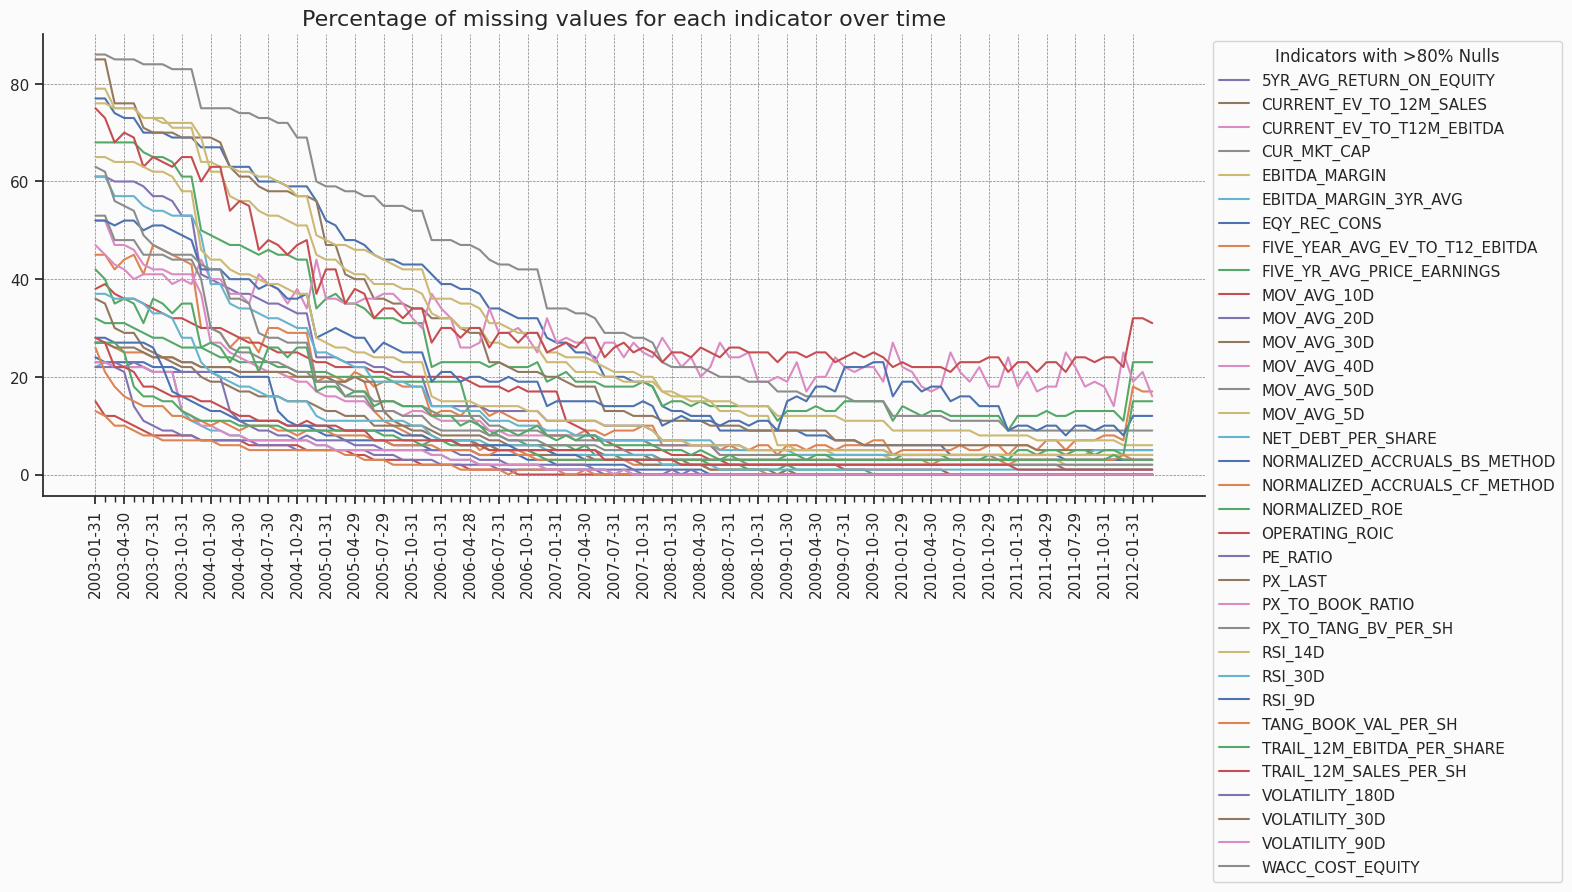

In [9]:
indicators = df.columns.get_level_values(0).unique()

# create dataframe to plot the data
null = {}

for ind in indicators:
  null[ind] = (
    df.stack().reset_index().drop('tickers',axis=1)
    .groupby('Date')[ind]
    .apply(lambda x: x.isnull().sum())
  )

null = pd.DataFrame.from_dict(null)
null = round(null / 797, 2) * 100

labels = df.index[::3]

plt.figure(figsize=(15,6))

# Plot the data
plt.plot(null)

plt.xticks(rotation=90, ha='center', labels=labels, ticks=range(0, len(df.index), 3))
plt.xticks(rotation=45, ha='right', labels=['']*len(df.index), ticks=range(len(df.index)), minor=True)

threshold = 80
indicators_with_high_nulls = null.columns[null.mean() > threshold / 100]
for indicator in indicators_with_high_nulls:
    plt.plot([], label=indicator)  # Empty plot to create space for legend

plt.legend(title='Indicators with >{}% Nulls'.format(threshold), loc='upper left', bbox_to_anchor=(1, 1))

plt.title('Percentage of missing values for each indicator over time', fontsize=16)

plt.show()

Even if at the beginning  of the time frame there are many null values for most of the factors in the dataset, we decided not to drop any more data to avoid introducing any more survivorship bias in our analyis.

## Preprocessing and Shifting



Look-ahead bias refers to a situation in data analysis or financial modeling where information that would not have been known or available at a certain point in time is improperly used to make predictions or decisions for that past period. This bias occurs when future data or information is inadvertently included in historical datasets, leading to an inaccurate representation of what information was actually available at the time.

In financial analysis, look-ahead bias can distort the evaluation of investment strategies, backtesting results, or performance metrics. It may lead to overestimating the effectiveness of a strategy because it mistakenly incorporates information that was not available at the time the decisions were made.

First, we compiled a list of factors derived from balance sheet data (financial_ratios list). We applied lagging to the whole dataset to account for reporting and release delays. So these balance sheet indicators where lagged of two time periods, while pure technical indicators were lagged only by one time period.

In [10]:
financial_ratios = [
    "PE_RATIO",
    "FIVE_YR_AVG_PRICE_EARNINGS",
    "T12M_DIL_PE_CONT_OPS",
    "10_YEAR_MOVING_AVERAGE_PE",
    "PX_TO_TANG_BV_PER_SH",
    "CURRENT_EV_TO_12M_SALES",
    "CURRENT_EV_TO_T12M_EBITDA",
    "FIVE_YEAR_AVG_EV_TO_T12_EBITDA",
    "T12M_DIL_EPS_CONT_OPS",
    "TRAIL_12M_EBITDA_PER_SHARE",
    "TRAIL_12M_SALES_PER_SH",
    "NET_DEBT_PER_SHARE",
    "TANG_BOOK_VAL_PER_SH",
    "NORMALIZED_ACCRUALS_CF_METHOD",
    "EBITDA_MARGIN",
    "EBITDA_MARGIN_3YR_AVG",
    "CAP_EXPEND_TO_SALES",
    "T12M_DVD_PAYOUT_RATIO",
    "EQY_DPS_NET_5YR_GROWTH",
    "NORMALIZED_ROE",
    "5YR_AVG_RETURN_ON_EQUITY",
    "NORMALIZED_ACCRUALS_BS_METHOD",
    "PX_TO_BOOK_RATIO"
]

# for every factor in the dataframe
for ind in indicators:
  # shifts two months if is the financial_ratios list
  if ind in financial_ratios:
    df[ind] = df[ind].shift(2)
  # else one
  else:
    df[ind] = df[ind].shift(1)

In [11]:
# dropping null rows
df = df.drop(['2003-01-31', '2003-02-28'])
returns = returns.drop(['2003-02-28'])
benchmark_returns = benchmark_returns.drop(['2003-02-28'])

In this part we created a few dataframe with different structures that will be useful later on to perform our analysis.

In [44]:
df2 = df.copy(deep=True)
# df2.drop(df2.head(1).index, inplace=True)

r = pd.DataFrame(returns.values, index=returns.index,
                 columns=pd.MultiIndex.from_product([['RETURNS'],
                                                     returns.columns]))

df2 = pd.concat([df2, r], axis=1)
data_stack = df2.stack()
data_stack.head()

indicators          5YR_AVG_RETURN_ON_EQUITY  CURRENT_EV_TO_12M_SALES  \
Date       tickers                                                      
2003-03-31 02P GR                        NaN                      NaN   
           1BM GR                        NaN                      NaN   
           1PL GR                        NaN                      NaN   
           1VS GR                        NaN                      NaN   
           2HR GR                        NaN                   0.5451   

indicators          CURRENT_EV_TO_T12M_EBITDA  CUR_MKT_CAP  EBITDA_MARGIN  \
Date       tickers                                                          
2003-03-31 02P GR                         NaN          NaN            NaN   
           1BM GR                         NaN          NaN            NaN   
           1PL GR                         NaN          NaN        25.0142   
           1VS GR                         NaN    1665.0000            NaN   
           2HR GR                      4.9943     110.6586        10.9136   

indicators          EBITDA_MARGIN_3YR_AVG  EQY_REC_CONS  \
Date       tickers                                        
2003-03-31 02P GR                     NaN           NaN   
           1BM GR                     NaN           NaN   
           1PL GR                     NaN           NaN   
           1VS GR                     NaN           NaN   
           2HR GR                     NaN           NaN   

indicators          FIVE_YEAR_AVG_EV_TO_T12_EBITDA  \
Date       tickers                                   
2003-03-31 02P GR                              NaN   
           1BM GR                              NaN   
           1PL GR                              NaN   
           1VS GR                              NaN   
           2HR GR                              NaN   

indicators          FIVE_YR_AVG_PRICE_EARNINGS  MOV_AVG_10D  ...  RSI_14D  \
Date       tickers                                           ...            
2003-03-31 02P GR                          NaN          NaN  ...      NaN   
           1BM GR                          NaN          NaN  ...      NaN   
           1PL GR                          NaN          NaN  ...      NaN   
           1VS GR                          NaN          NaN  ...      NaN   
           2HR GR                          NaN       4.3757  ...  44.7583   

indicators          RSI_30D   RSI_9D  TANG_BOOK_VAL_PER_SH  \
Date       tickers                                           
2003-03-31 02P GR       NaN      NaN                   NaN   
           1BM GR       NaN      NaN                   NaN   
           1PL GR       NaN      NaN                   NaN   
           1VS GR       NaN      NaN                   NaN   
           2HR GR   57.8923  38.6861                1.7176   

indicators          TRAIL_12M_EBITDA_PER_SHARE  TRAIL_12M_SALES_PER_SH  \
Date       tickers                                                       
2003-03-31 02P GR                          NaN                     NaN   
           1BM GR                          NaN                     NaN   
           1PL GR                          NaN                     NaN   
           1VS GR                          NaN                     NaN   
           2HR GR                       0.7867                  7.2082   

indicators          VOLATILITY_180D  VOLATILITY_30D  VOLATILITY_90D  \
Date       tickers                                                    
2003-03-31 02P GR               NaN             NaN             NaN   
           1BM GR               NaN          59.773             NaN   
           1PL GR               NaN             NaN             NaN   
           1VS GR               NaN          46.864             NaN   
           2HR GR            39.094          43.347          34.569   

indicators          WACC_COST_EQUITY  
Date       tickers                    
2003-03-31 02P GR                NaN  
           1BM GR                NaN  
       

## Univariate Ranking

Univariate stock ranking is a method of evaluating and ranking individual stocks based on a single, specific criterion or factor. Instead of considering multiple factors simultaneously, univariate stock ranking focuses on a single variable to assess the relative strength or performance of different stocks.

Univariate stock ranking simplifies the analysis by focusing on a single factor, allowing investors to quickly identify and compare stocks based on that specific criterion. However, it's important to note that a comprehensive stock analysis often involves considering multiple factors to gain a more holistic view of a stock's potential.

The `calculate_quantile_returns` function takes a DataFrame containing stock-specific factor values, divides them into quantiles, and computes returns for each quantile. This facilitates the assessment of how a specified factor influences stock returns. Additionally, the `calculate_IR` function calculates the Information Ratio (IR), a metric that measures the excess return of a portfolio relative to a benchmark, considering the associated tracking error. These functions are useful for evaluating and comparing the performance of investment strategies based on specific factors, aiding in the identification of potential alpha-generating opportunities.

In [13]:
def calculate_quantile_returns(data_frame, column_name, returns_df, num_quantiles=5):

    """
    Calculate quantile returns based on the specified factor in the DataFrame.
    """

    quantile_ranks = pd.DataFrame(index=data_frame.index, columns=data_frame.columns.levels[1])
    ind_rank = data_frame[column_name]
    ind_rank = ind_rank.replace(0, np.nan)

    # ranking stock for every date based on the values of the month
    # before (if we consider a fundamental factor)
    for date in ind_rank.index:
        row_values = ind_rank.loc[date]

        if row_values.count() > 1:
            ranks = pd.Series(row_values).rank(method='max')
            quintiles = pd.qcut(ranks, q=num_quantiles, labels=False)
            quantile_ranks.loc[date] = quintiles

    # calculate returns for each quantile
    quantile_dfs = {}
    portfolio_returns = pd.DataFrame()

    for quantile in range(num_quantiles):
        filtered_df = returns_df[quantile_ranks == quantile]
        filtered_df_shifted = filtered_df
        quantile_dfs[quantile] = filtered_df_shifted
        portfolio_returns[quantile] = quantile_dfs[quantile].mean(axis=1).dropna()

    return quantile_dfs, portfolio_returns


def calculate_IR(portfolio_returns, benchmark_returns):
    """
    Calculate the Information Ratio.
    """

    active_return = portfolio_returns-benchmark_returns
    tracking_error = np.std(portfolio_returns-benchmark_returns)


    return active_return.mean() / tracking_error

### Evaluate the performances

#### Information Ratio (IR) in Financial Analysis

The Information Ratio (IR) is a widely-used metric in financial analysis that assesses the risk-adjusted performance of an investment strategy or portfolio compared to a benchmark. It provides insight into the excess return generated per unit of tracking error, offering a measure of the portfolio manager's skill in generating returns beyond the benchmark.

**Calculation:**

The Information Ratio is calculated using the following formula:

$$\text{IR} = \frac{\text{Active Return}}{\text{Tracking Error}}$$

Where:
- **Active Return** is the portfolio return minus the benchmark return.
- **Tracking Error** is the standard deviation of the active return.

**Interpretation:**

- A positive Information Ratio indicates that the portfolio has outperformed the benchmark on a risk-adjusted basis.
- A higher IR suggests a better risk-adjusted performance.
- A negative IR implies underperformance relative to the benchmark.

#### Benchmark

As for the benchmark we decided to use a portfolio built with all the stocks in the stock universe (equally weighted) to test whether is worth it or not to select stock based our strategies.

In [14]:

# create dataframe
indicator_IR = pd.DataFrame(index=indicators, columns=['IR_top_quantile', 'IR_bottom_quantile', 'tracking_top_quantile',
                                                       'tracking_error_bottom_quantile', 'returns_top_quantile', 'returns_bottom_quantile'])

# calculate IR for every univariate portfolio (first and last)
for indicator in indicators:
    result_dfs, portfolio_returns = calculate_quantile_returns(df, indicator, returns)
    indicator_IR.at[indicator, 'IR_top_quantile'] = calculate_IR(portfolio_returns[4], benchmark_returns)
    indicator_IR.at[indicator, 'IR_bottom_quantile'] = calculate_IR(portfolio_returns[0], benchmark_returns)
    indicator_IR.at[indicator, 'tracking_top_quantile'] = np.std(portfolio_returns[4]-benchmark_returns)
    indicator_IR.at[indicator, 'tracking_error_bottom_quantile'] = np.std(portfolio_returns[0]-benchmark_returns)
    indicator_IR.at[indicator, 'returns_top_quantile'] = np.mean(portfolio_returns[4]) * 100
    indicator_IR.at[indicator, 'returns_bottom_quantile'] = np.mean(portfolio_returns[0]) * 100


indicator_IR.sort_values('IR_top_quantile', ascending = False)

IR_top_quantile IR_bottom_quantile  \
indicators                                                          
OPERATING_ROIC                        0.304748          -0.166042   
RSI_9D                                0.210018           -0.12245   
RSI_14D                               0.191676          -0.059058   
VOLATILITY_180D                       0.174545          -0.063117   
NORMALIZED_ROE                        0.148755          -0.069542   
RSI_30D                               0.145714           0.053475   
EQY_REC_CONS                          0.140719          -0.393348   
VOLATILITY_90D                        0.088235          -0.051333   
5YR_AVG_RETURN_ON_EQUITY              0.058878            0.06943   
TANG_BOOK_VAL_PER_SH                  0.056614          -0.319039   
VOLATILITY_30D                        0.005428          -0.023415   
EBITDA_MARGIN_3YR_AVG                -0.023648           0.056427   
TRAIL_12M_EBITDA_PER_SHARE           -0.055278           0.047258   
EBITDA_MARGIN                        -0.059931          -0.015041   
TRAIL_12M_SALES_PER_SH                 -0.0993            0.11473   
NORMALIZED_ACCRUALS_CF_METHOD        -0.135434             0.3276   
MOV_AVG_40D                          -0.175454           0.364287   
MOV_AVG_50D                          -0.176695            0.40082   
CUR_MKT_CAP                           -0.18022           0.811813   
PX_LAST                              -0.188447           0.295789   
WACC_COST_EQUITY                     -0.199441           0.152515   
NORMALIZED_ACCRUALS_BS_METHOD        -0.214264            0.33006   
MOV_AVG_30D                          -0.215667           0.393491   
PX_TO_BOOK_RATIO                     -0.220638           0.207121   
MOV_AVG_5D                           -0.223019           0.326325   
FIVE_YR_AVG_PRICE_EARNINGS           -0.232285           0.375272   
MOV_AVG_10D                           -0.25867           0.411834   
MOV_AVG_20D                          -0.272896           0.396734   
FIVE_YEAR_AVG_EV_TO_T12_EBITDA       -0.273758           0.510098   
PE_RATIO                             -0.274399           0.461267   
CURRENT_EV_TO_12M_SALES              -0.281967           0.330831   
PX_TO_TANG_BV_PER_SH                 -0.303497           0.255615   
NET_DEBT_PER_SHARE                   -0.309904           0.268086   
CURRENT_EV_TO_T12M_EBITDA            -0.383046             0.6068   

                               tracking_top_quantile  \
indicators                                             
OPERATING_ROIC                              0.010431   
RSI_9D                                      0.021912   
RSI_14D                                     0.021344   
VOLATILITY_180D                             0.024252   
NORMALIZED_ROE                               0.01086   
RSI_30D                                     0.019686   
EQY_REC_CONS                                 0.01242   
VOLATILITY_90D                              0.023252   
5YR_AVG_RETURN_ON_EQUITY                    0.011251   
TANG_BOOK_VAL_PER_SH                        0.010401   
VOLATILITY_30D                              0.022256   
EBITDA_MARGIN_3YR_AVG                       0.014342   
TRAIL_12M_EBITDA_PER_SHARE                  0.010475   
EBITDA_MARGIN                               0.011927   
TRAIL_12M_SALES_PER_SH                      0.009289   
NORMALIZED_ACCRUALS_CF_METHOD               0.009503   
MOV_AVG_40D                                 0.010778   
MOV_AVG_50D                                 0.010293   
CUR_MKT_CAP                                 0.013196   
PX_LAST                                     0.014457   
WACC_COST_EQUITY                            0.023864   
NORMALIZED_ACCRUALS_BS_METHOD               0.009848   
MOV_AVG_30D                                  0.01087   
PX_TO_BOOK_RATIO                            0.013952   
MOV_AVG_5D                                  0.013749   
FIVE_YR_AVG_PRICE_EARNINGS        

In the *indicator_IR* table there are the results of all univariate strategies for every single indicator. We will comment only the results of portfolios with an Information Ratio greater than 0.4

In [15]:
selected_rows = (
    (indicator_IR['IR_top_quantile'] > 0.40) |
    (indicator_IR['IR_bottom_quantile'] > 0.40)
)

indicator_IR[selected_rows]

IR_top_quantile IR_bottom_quantile  \
indicators                                                          
CURRENT_EV_TO_T12M_EBITDA            -0.383046             0.6068   
CUR_MKT_CAP                           -0.18022           0.811813   
FIVE_YEAR_AVG_EV_TO_T12_EBITDA       -0.273758           0.510098   
MOV_AVG_10D                           -0.25867           0.411834   
MOV_AVG_50D                          -0.176695            0.40082   
PE_RATIO                             -0.274399           0.461267   

                               tracking_top_quantile  \
indicators                                             
CURRENT_EV_TO_T12M_EBITDA                   0.013147   
CUR_MKT_CAP                                 0.013196   
FIVE_YEAR_AVG_EV_TO_T12_EBITDA              0.016777   
MOV_AVG_10D                                 0.012868   
MOV_AVG_50D                                 0.010293   
PE_RATIO                                     0.00942   

                               tracking_error_bottom_quantile  \
indicators                                                      
CURRENT_EV_TO_T12M_EBITDA                            0.013129   
CUR_MKT_CAP                                          0.013671   
FIVE_YEAR_AVG_EV_TO_T12_EBITDA                       0.013709   
MOV_AVG_10D                                          0.015827   
MOV_AVG_50D                                          0.014736   
PE_RATIO                                             0.013276   

                               returns_top_quantile returns_bottom_quantile  
indicators                                                                   
CURRENT_EV_TO_T12M_EBITDA                  0.081621                1.381887  
CUR_MKT_CAP                                0.347402                1.695077  
FIVE_YEAR_AVG_EV_TO_T12_EBITDA             0.125941                1.284524  
MOV_AVG_10D                                0.252367                1.237034  
MOV_AVG_50D                                0.403349                 1.17587  
PE_RATIO                                   0.326731                1.197595

The Indicators with an IR>0.4 perform better in the bottom quantile. A low P/E ratio may indicate undervaluation, making these stocks potentially attractive. Investors following this strategy seek companies with stable earnings, dividend potential, and a contrarian approach, aiming for a margin of safety. This is why the bottom quantile in case of the PE_RATIO performs better.


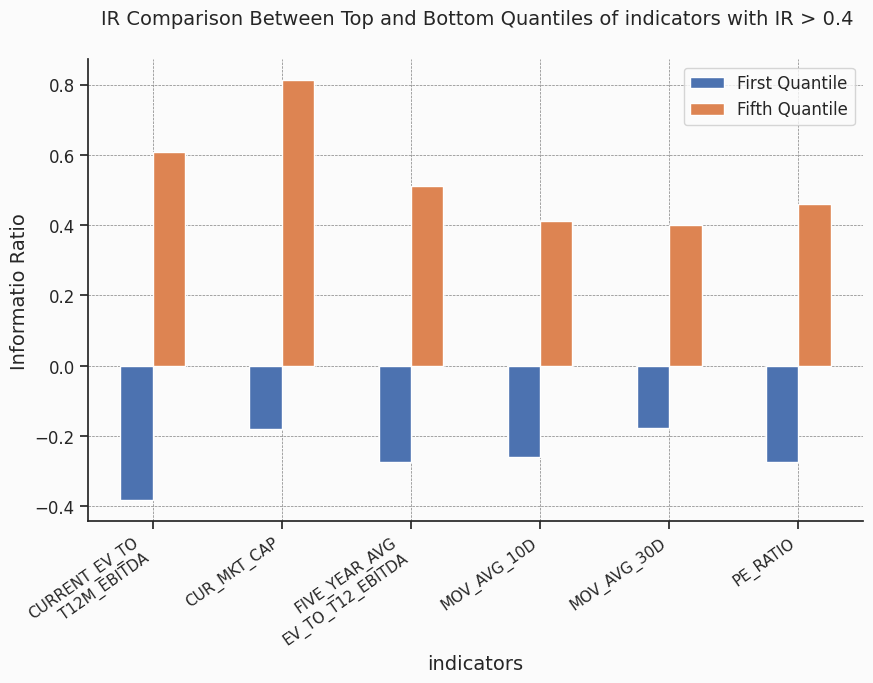

In [16]:
# Selecting columns for plotting
selected_columns = ['IR_top_quantile', 'IR_bottom_quantile']

labels = ['CURRENT_EV_TO\nT12M_EBITDA', 'CUR_MKT_CAP',
       'FIVE_YEAR_AVG\nEV_TO_T12_EBITDA', 'MOV_AVG_10D', 'MOV_AVG_30D',
       'PE_RATIO']

# Plotting the selected data
ax = indicator_IR[selected_rows][selected_columns].plot(kind='bar', figsize=(10, 6))

Xstart, Xend = ax.get_xlim()
Ystart, Yend = ax.get_ylim()

ax.text(Xstart+0.1, Yend+0.1, '''IR Comparison Between Top and Bottom Quantiles of indicators with IR > 0.4''', fontsize=14)

plt.xlabel('indicators', fontsize=14)
plt.ylabel('Informatio Ratio', fontsize=14)
plt.legend(['First Quantile', 'Fifth Quantile'], fontsize=12)
ax.set_xticklabels(labels, rotation=35, ha='right')
plt.yticks(fontsize=12)
plt.show()



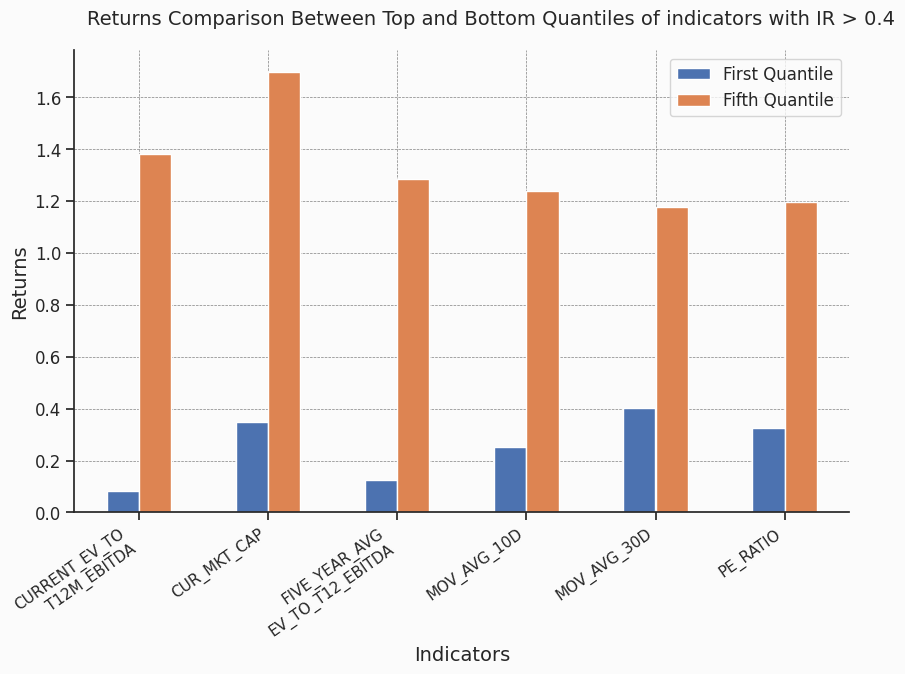

In [17]:
# Selecting columns for plotting
selected_columns = ['returns_top_quantile', 'returns_bottom_quantile']


# Plotting the selected data
ax = indicator_IR[selected_rows][selected_columns].plot(kind='bar', figsize=(10, 6))

Xstart, Xend = ax.get_xlim()
Ystart, Yend = ax.get_ylim()

ax.text(Xstart+0.1, Yend+0.1,'''Returns Comparison Between Top and Bottom Quantiles of indicators with IR > 0.4''', fontsize=14)

plt.xlabel('Indicators', fontsize=14)
plt.ylabel('Returns', fontsize=14)
plt.legend(['First Quantile', 'Fifth Quantile'], fontsize=12)
ax.set_xticklabels(labels, rotation=35, ha='right')
plt.yticks(fontsize=12)
plt.show()



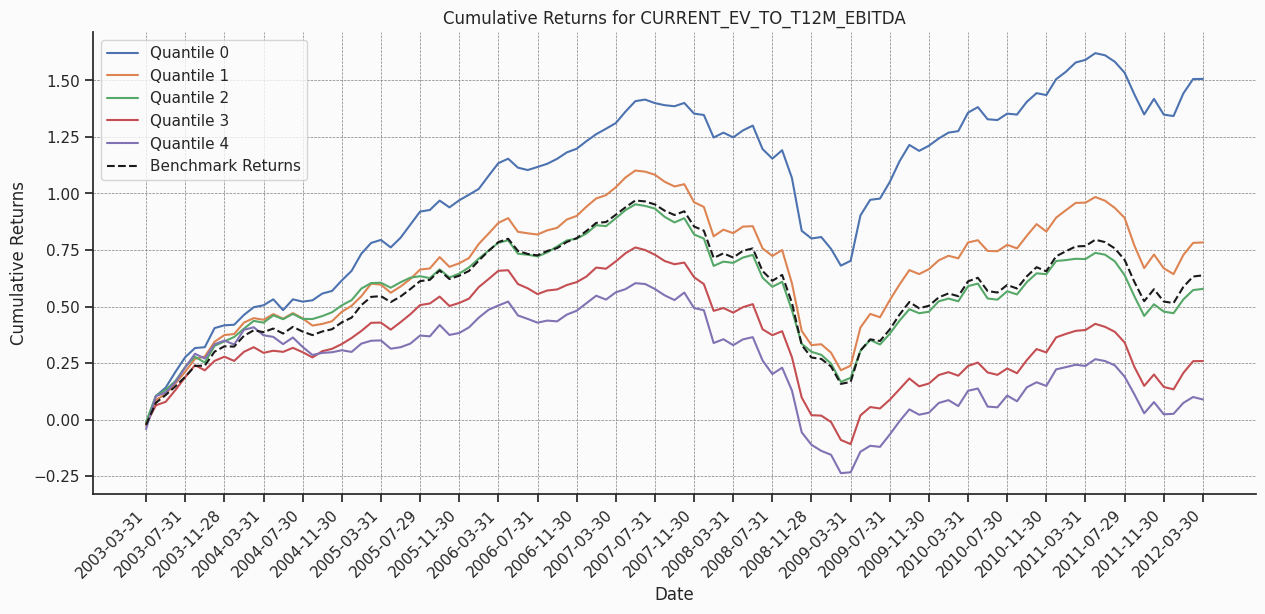

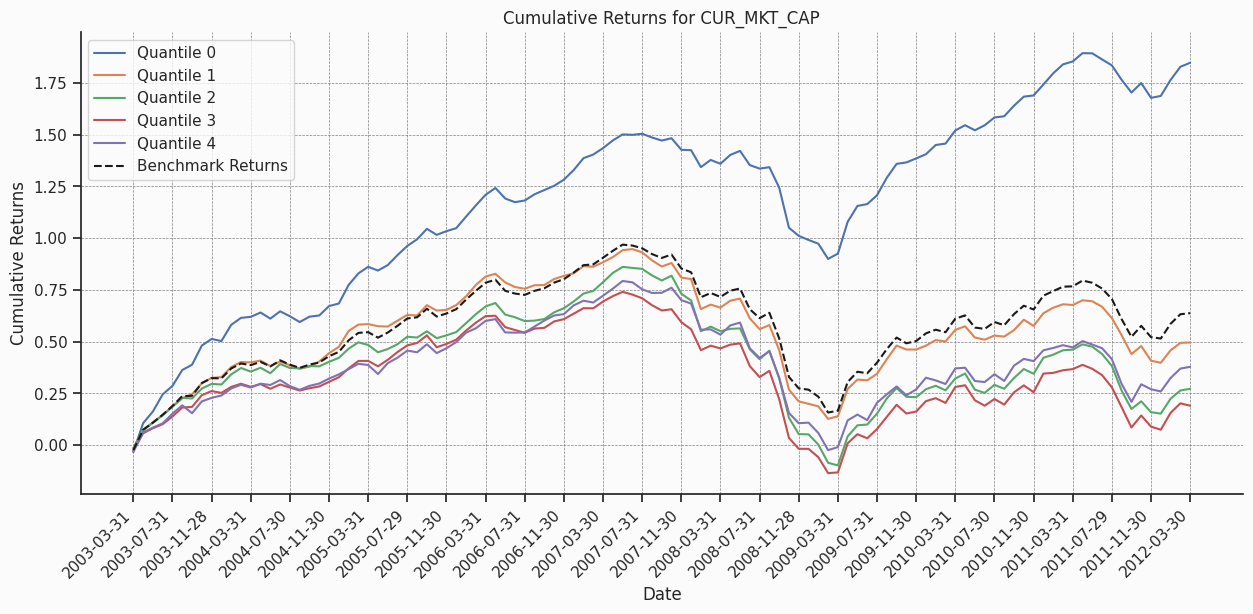

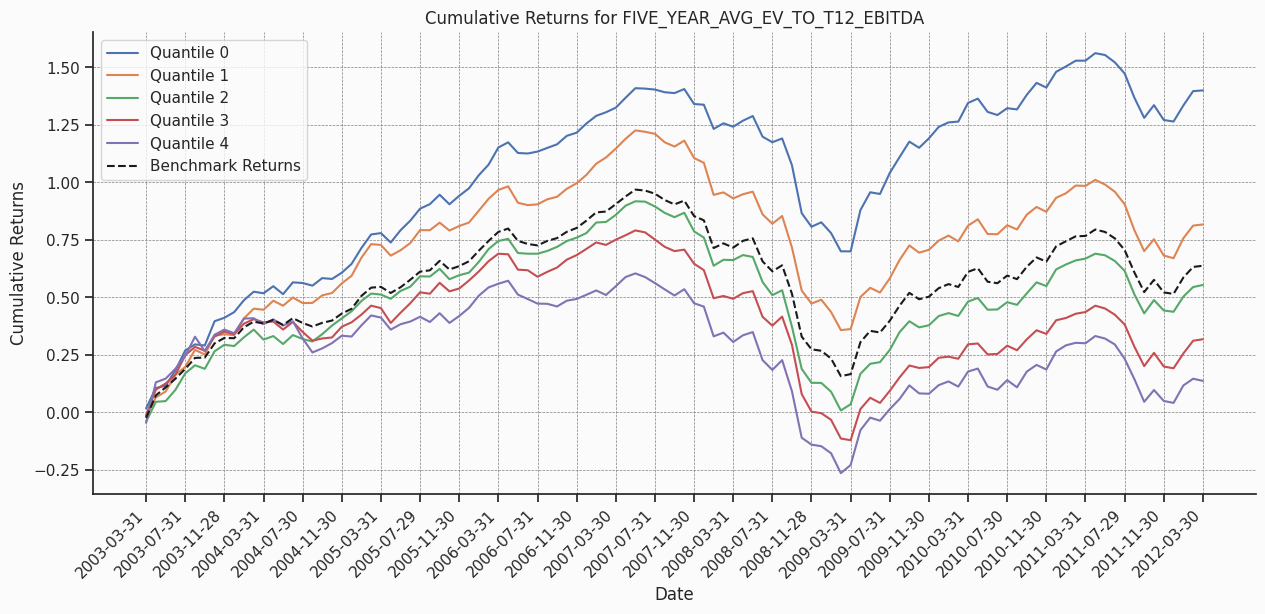

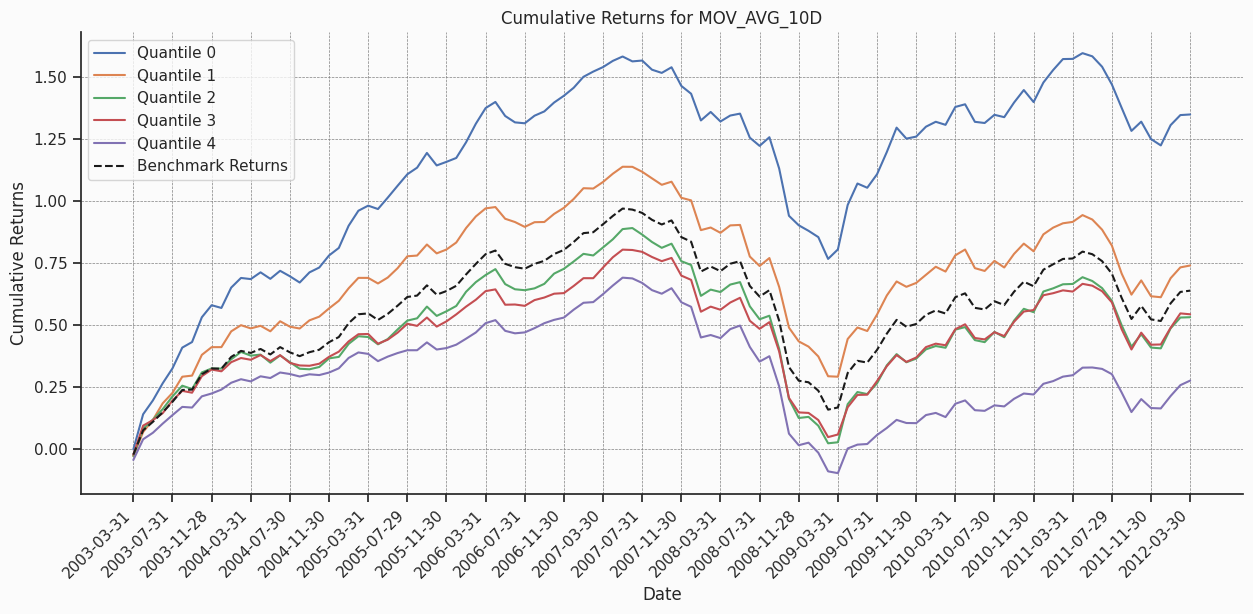

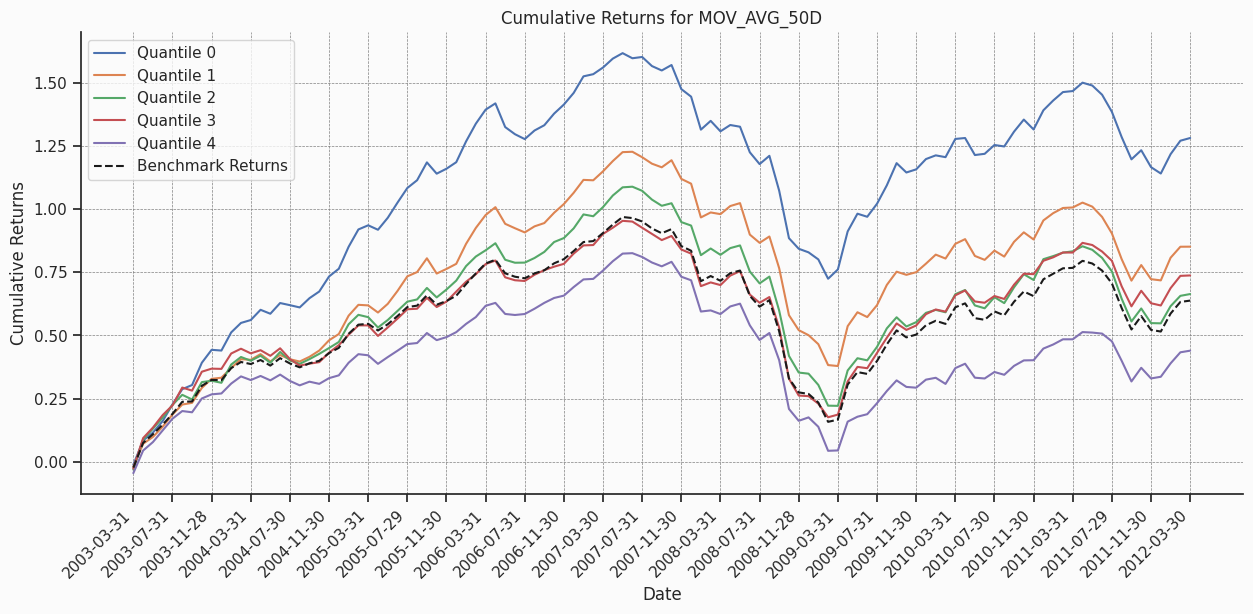

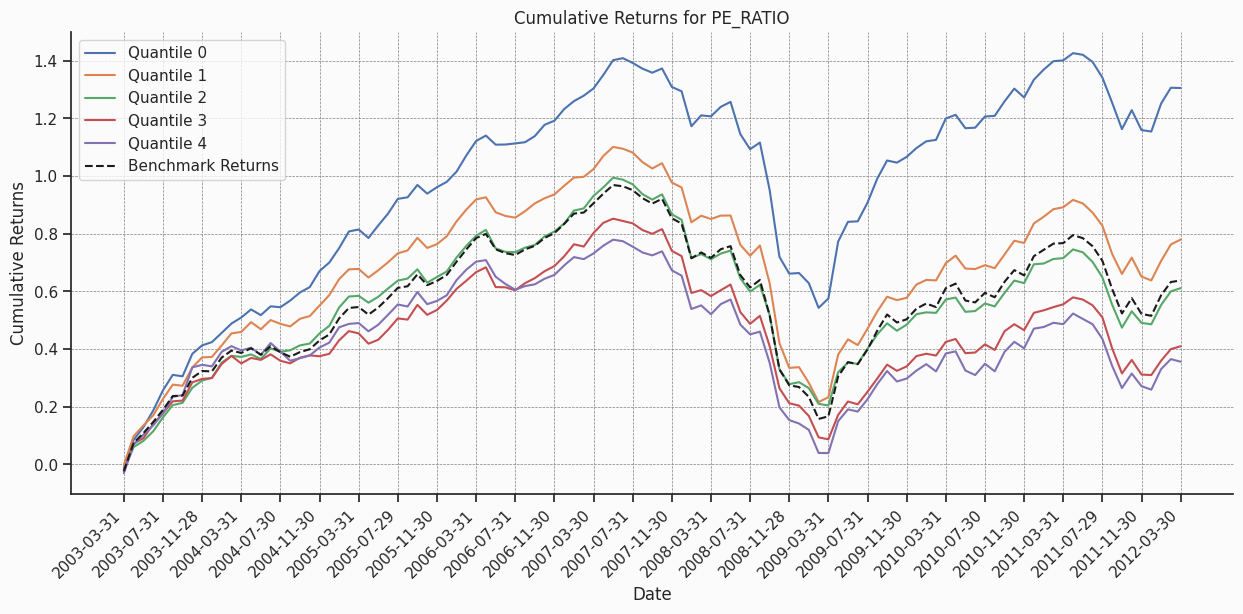

In [18]:
for ind in indicator_IR[selected_rows].index:
    result_dfs, portfolio_returns = calculate_quantile_returns(df, ind, returns)

    plt.figure(figsize=(15, 6))

    # Iterate through quantiles
    for quantile in range(len(portfolio_returns.columns)):
        plt.plot(portfolio_returns[quantile].cumsum(), label=f"Quantile {quantile}")

    plt.plot(benchmark_returns.cumsum(), 'k--', label='Benchmark Returns')
    plt.title(f"Cumulative Returns for {ind}")
    plt.xlabel("Date")
    plt.ylabel("Cumulative Returns")

    # Set x ticks for every 4 months
    plt.xticks(range(0, len(portfolio_returns), 4), portfolio_returns.index[::4], rotation=45, ha='right')

    plt.legend()
    plt.show()


### Correlation

In general, a perfect correlation (i.e., a correlation of 1) indicates that the two factors are almost identical, whereas a correlation of 0 would indicate that the factors are quite independent. In the extreme cases of perfect positive or negative correlation, the two factors are more likely to be redundant.

To assess the correlation between factors we decided to use Kendall rank's correlation. if Kendall’s τ is 1, then for every pair of observations, the ranking by one variable is always identical to the ranking by another variable. If Kendall’s τ is -1, then for every pair of observations, the rankings by two variables are opposite. If Kendall’s τ is 0, half the time the rankings by two variables are the same, and the other half of the time the rankings are opposite.

We ran some correlation tests on the overall dataset and we found two particular clusters of correlations
1. between moving averages
2. between RSI measures

On these two clusters we decided to keep the measure that has the highest absolute IR, which are:
- the moving average for 10 days
- the RSI_9D

In [19]:
sns.set_palette('Set2')

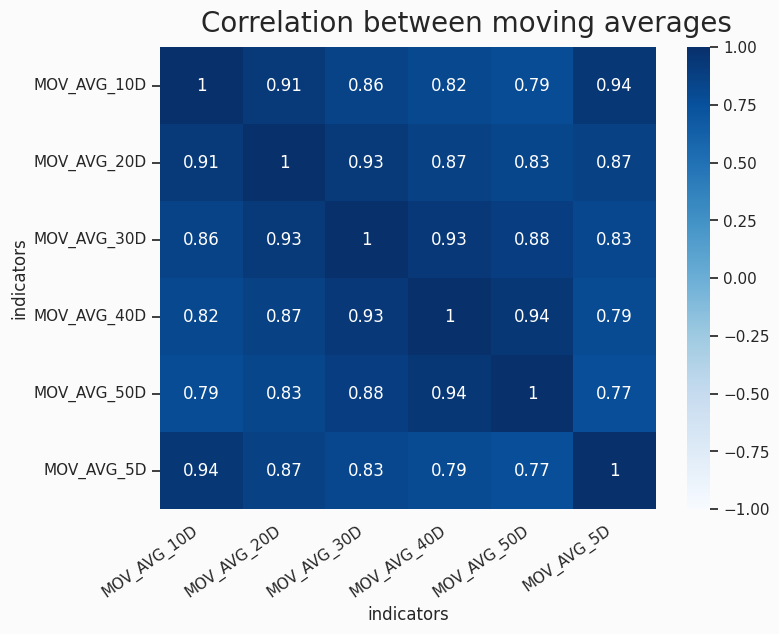

In [20]:
# correlation for the moving average cluster
top = (
    (indicator_IR['IR_top_quantile'] > 0) |
    (indicator_IR['IR_bottom_quantile'] > 0)
)

mov_avg = ['MOV_AVG_10D', 'MOV_AVG_20D', 'MOV_AVG_30D', 'MOV_AVG_40D', 'MOV_AVG_50D', 'MOV_AVG_5D']
cluster_mov_avg = df[indicator_IR[top].index][mov_avg].stack().corr(method='kendall')
fig, ax = plt.subplots(figsize=(8,6))
sns.heatmap(cluster_mov_avg, vmin=-1, vmax=1, cmap='Blues', annot=True, cbar=True)
Xstart, Xend = ax.get_xlim()
Ystart, Yend = ax.get_ylim()

ax.text(Xstart+0.5, Yend-0.2,

        '''Correlation between moving averages''', fontsize=20)

x_tick_positions = [0, 1, 2, 3, 4, 5]  # Adjust the positions as needed
#ax.set_xticks(x_§tick_positions)

ax.set_xticklabels(mov_avg, rotation=35, ha='right')
ax.set_yticklabels(mov_avg, rotation=0)

#ax.set_xticks([])
ax.xaxis.set_ticks_position('none')
for s in ['top','right','bottom','left']:
    ax.spines[s].set_visible(False)
#plt.savefig("new_heatmap.png")
#plt.tight_layout()
plt.show()

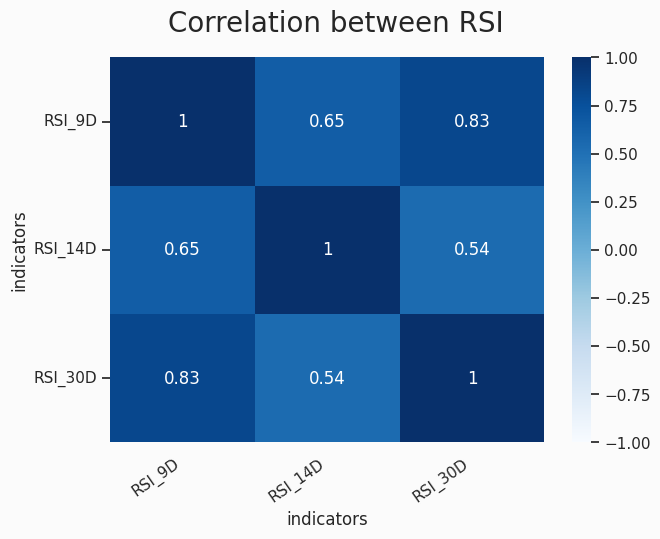

In [21]:
# correlation for RSI cluster

rsi = ['RSI_9D', 'RSI_14D', 'RSI_30D']
cluster_rsi = df[indicator_IR[top].index][rsi].stack().corr(method='kendall')
fig, ax = plt.subplots(figsize=(7,5))
sns.heatmap(cluster_rsi, vmin=-1, vmax=1, cmap='Blues', annot=True, cbar=True)
Xstart, Xend = ax.get_xlim()
Ystart, Yend = ax.get_ylim()

ax.text(Xstart+0.4, Yend-0.2,

        '''Correlation between RSI''', fontsize=20)

x_tick_positions = [0, 1, 2]

ax.set_xticklabels(rsi, rotation=35, ha='right')
ax.set_yticklabels(rsi, rotation=0)

#ax.set_xticks([])
ax.xaxis.set_ticks_position('none')
for s in ['top','right','bottom','left']:
    ax.spines[s].set_visible(False)
plt.show()

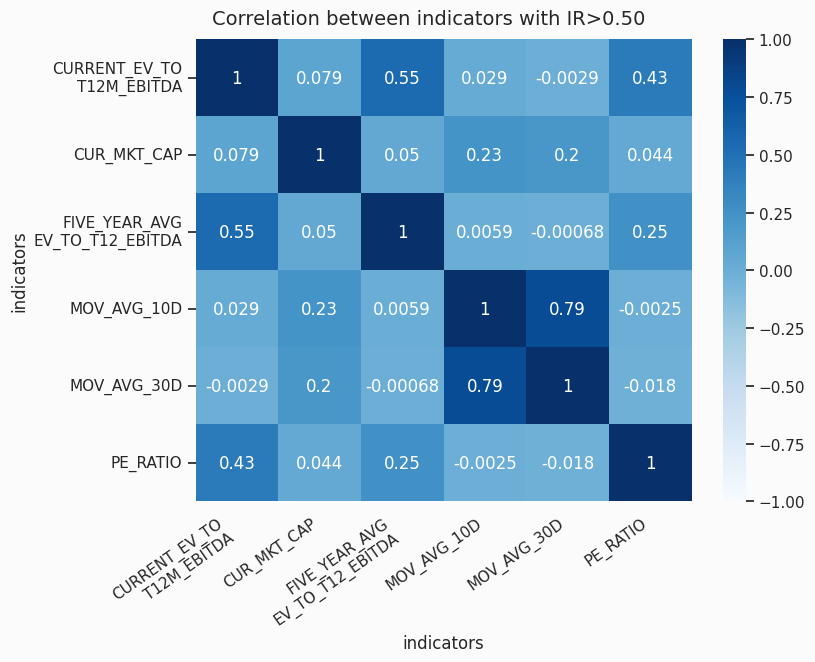

In [22]:
top = [i for i in indicator_IR[indicator_IR['IR_top_quantile']>0.40].index]
top.extend(i for i in indicator_IR[indicator_IR['IR_bottom_quantile']>0.40].index)

corr = df[top].stack().corr(method='kendall')
fig, ax = plt.subplots(figsize=(8,6))
sns.heatmap(corr, vmin=-1, vmax=1, cmap='Blues', annot=True, cbar=True)
Xstart, Xend = ax.get_xlim()
Ystart, Yend = ax.get_ylim()

ax.text(Xstart+0.2, Yend-0.2, '''Correlation between indicators with IR>0.50''', fontsize=14)

# x_tick_positions = [0, 1, 2, 3, 4, 5,6]  # Adjust the positions as needed
#ax.set_xticks(x_tick_positions)

ax.set_xticklabels(labels, rotation=35, ha='right')
ax.set_yticklabels(labels, rotation=0)

#ax.set_xticks([])
ax.xaxis.set_ticks_position('none')
for s in ['top','right','bottom','left']:
    ax.spines[s].set_visible(False)
#plt.savefig("new_heatmap.png")
#plt.tight_layout()
plt.show()

### Turnover

We decided to set commission costs to zero, but still we wanted to perform a Turnover analysis on the univariate strategies to see which indicators give a greater turnover over the stock selection that would lead to larger costs.

In [23]:
# saving in the dataframes 'first_quantile_stocks' and 'last_quantile_stocks'
# all the tickers of the stocks that have been selected for every timestamp

first_quantile_stocks = pd.DataFrame(index=df.index, columns=indicators)
last_quantile_stocks = pd.DataFrame(index=df.index, columns=indicators)


# Loop through each indicator
for ind in indicators:
    result_dfs, portfolio_returns = calculate_quantile_returns(df, ind, returns)

    # For each date, store the list of best stocks in the corresponding column
    for index, row in result_dfs[4].iterrows():
        first_quantile_stocks.loc[index, ind] = list(row.dropna().index)

    for index, row in result_dfs[0].iterrows():
        last_quantile_stocks.loc[index, ind] = list(row.dropna().index)


first_quantile_date = first_quantile_stocks.reset_index()
last_quantile_date = last_quantile_stocks.reset_index()


turnover_first_quantile = pd.DataFrame(index = df.index)
turnover_last_quantile = pd.DataFrame(index = df.index)

lengths_first_quantile = pd.DataFrame(index = df.index)
lengths_last_quantile = pd.DataFrame(index = df.index)


# this function calculates the turnover by confronting the stocks in the
# portfolio at the time t and t-1
def turnover_select(indicator, stocks, stocks_date):


    expanded_df2 = stocks[indicator].explode()
    merged_df = pd.merge(stocks_date[[indicator, 'Date']],
                         expanded_df2, how='right',
                         left_on='Date', right_on='Date')

    changed_stocks = (
        merged_df.groupby('Date')[indicator + '_y']
        .apply(set)
        .diff()
        .apply(lambda x: list(x) if isinstance(x, set) else [])
    )

    lenght_stocks = (
      merged_df.groupby('Date')[indicator+ '_y']
      .count()
    )

    if stocks.equals(first_quantile_stocks) and stocks_date.equals(first_quantile_date):
      lengths_first_quantile[indicator] = lenght_stocks
      turnover_first_quantile[indicator] = changed_stocks.apply(lambda x: len(x))

    elif stocks.equals(last_quantile_stocks) and stocks_date.equals(last_quantile_date):
      lengths_last_quantile[indicator] = lenght_stocks
      turnover_last_quantile[indicator] = changed_stocks.apply(lambda x: len(x))

# apply the function for every indicator in the dataset
for ind in indicators:

    turnover_select(indicator=ind,
                    stocks=first_quantile_stocks,
                    stocks_date=first_quantile_date)

    turnover_select(indicator=ind,
                    stocks=last_quantile_stocks,
                    stocks_date= last_quantile_date)


# we dropped the first row of the turnover datasets since it's zero
turnover_first_quantile.drop(['2003-03-31'], axis=0, inplace=True)
turnover_last_quantile.drop(['2003-03-31'], axis=0, inplace=True)
lengths_first_quantile.drop(['2003-03-31'], axis=0, inplace=True)
lengths_last_quantile.drop(['2003-03-31'], axis=0, inplace=True)

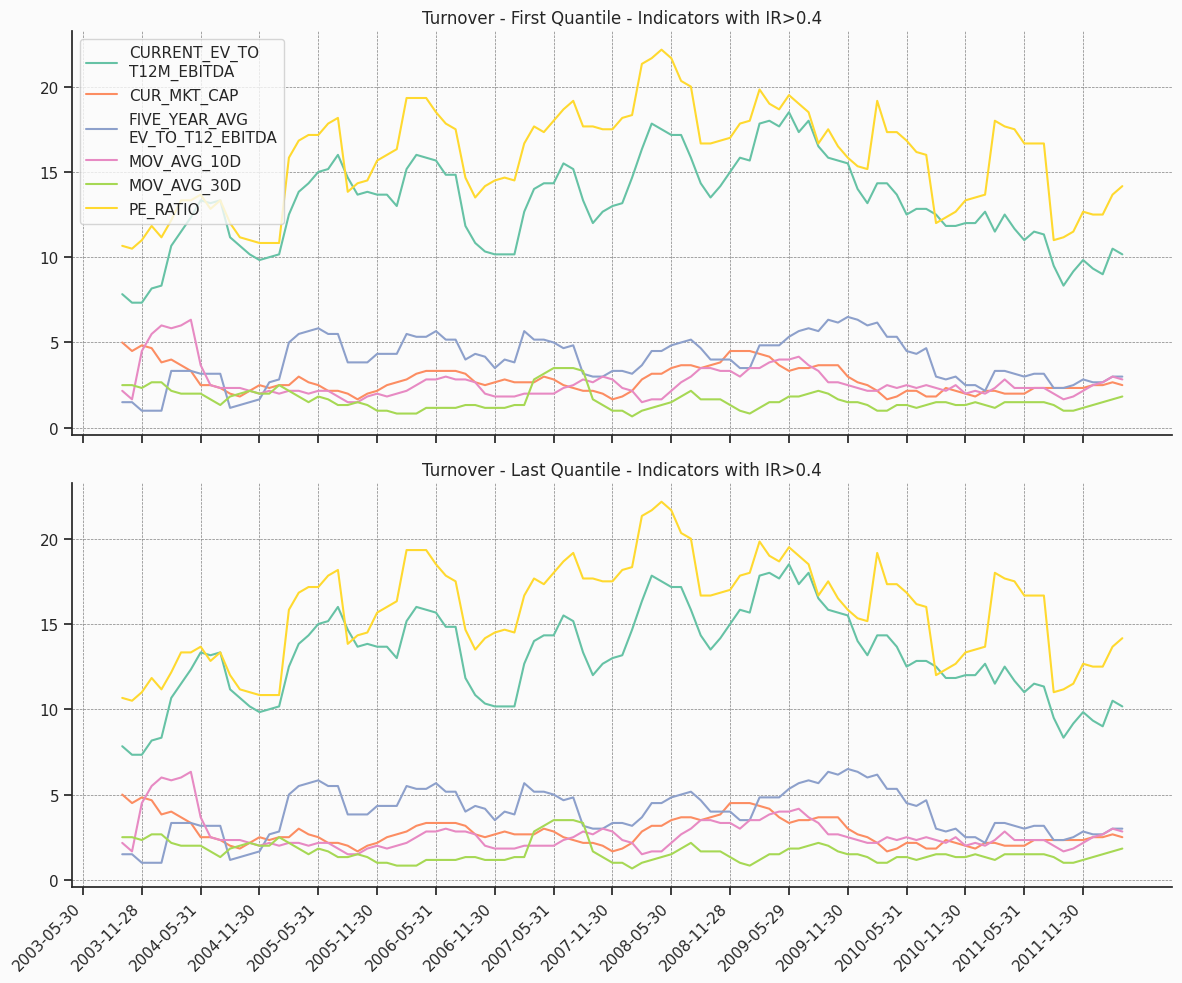

In [24]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10), sharex=True)

# Plot and format the first subplot
for column, label in zip(top, labels):
    ax1.plot(turnover_first_quantile[column].rolling(6).mean(), label=label)
ax1.set_title('Turnover - First Quantile - Indicators with IR>0.4')
ax1.grid(True, which='both', linestyle='--', linewidth=0.5)  # Add gridlines
ax1.legend()  # Add legend

# Plot and format the second subplot
ax2.plot(turnover_first_quantile[top].rolling(6).mean())
ax2.set_title('Turnover - Last Quantile - Indicators with IR>0.4')
ax2.grid(True, which='both', linestyle='--', linewidth=0.5)  # Add gridlines

xticks_major = ax2.get_xticks()[1::6]  # Adjust the step as needed
xtick_labels = turnover_first_quantile.index[xticks_major]
ax2.set_xticks(xticks_major)
ax2.set_xticklabels(xtick_labels, rotation=45, ha='right')

plt.tight_layout()
plt.show()


We report the turnover as a rolling mean of 6 months for the Indicators with an IR greater than 0.4. As we can see the longer the time frame considered by the indicator the less will be the turnover on the stock selection. For example it's more noticeble from the chart how the 'CURRENT_EV_TO_T12M_EBITDA' has always an higher turnover than the 'FIVE_YEAR_AVG_TO_EV_T12_EBITDA'.

In [25]:
# We are calculating some summary statistics of the turnver for each indicator

rel_first_quantile = round(turnover_first_quantile / lengths_first_quantile,2) * 100
rel_last_quantile = round(turnover_last_quantile / lengths_last_quantile,2) * 100

stats = round(turnover_first_quantile.mean(),2).reset_index()
stats.columns = ['indicators', 'average_first_quantile']

stats2 = round(turnover_last_quantile.mean(),2).reset_index()
stats2.columns = ['indicators', 'average_last_quantile']

stats3 = round(rel_first_quantile.mean(),2).reset_index()
stats3.columns = ['indicators', 'average_perc_first_quantile']

stats4 = round(rel_last_quantile.mean(),2).reset_index()
stats4.columns = ['indicators', 'average__perc_last_quantile']

stats3 = stats3.merge(stats4, how='inner', on='indicators')
stats = stats.merge(stats2, how='inner', on='indicators')

stats = stats.merge(stats3, how='inner', on='indicators')

In [26]:
stats.sort_values(by='average_first_quantile', ascending=False)

indicators  average_first_quantile  \
31                  VOLATILITY_30D                   51.22   
6                     EQY_REC_CONS                   33.68   
26                          RSI_9D                   33.48   
24                         RSI_14D                   26.65   
32                  VOLATILITY_90D                   20.94   
25                         RSI_30D                   17.19   
16   NORMALIZED_ACCRUALS_BS_METHOD                   16.36   
20                        PE_RATIO                   15.67   
2        CURRENT_EV_TO_T12M_EBITDA                   12.93   
17   NORMALIZED_ACCRUALS_CF_METHOD                   11.56   
30                 VOLATILITY_180D                   11.55   
22                PX_TO_BOOK_RATIO                   11.11   
33                WACC_COST_EQUITY                   10.40   
23            PX_TO_TANG_BV_PER_SH                    9.06   
1          CURRENT_EV_TO_12M_SALES                    7.80   
5            EBITDA_MARGIN_3YR_AVG                    7.66   
21                         PX_LAST                    5.76   
18                  NORMALIZED_ROE                    5.71   
19                  OPERATING_ROIC                    5.24   
8       FIVE_YR_AVG_PRICE_EARNINGS                    4.55   
15              NET_DEBT_PER_SHARE                    3.95   
7   FIVE_YEAR_AVG_EV_TO_T12_EBITDA                    3.88   
4                    EBITDA_MARGIN                    3.82   
0         5YR_AVG_RETURN_ON_EQUITY                    3.78   
14                      MOV_AVG_5D                    3.20   
28      TRAIL_12M_EBITDA_PER_SHARE                    3.16   
27            TANG_BOOK_VAL_PER_SH                    2.98   
3                      CUR_MKT_CAP                    2.85   
9                      MOV_AVG_10D                    2.65   
10                     MOV_AVG_20D                    2.23   
11                     MOV_AVG_30D                    1.96   
29          TRAIL_12M_SALES_PER_SH                    1.85   
12                     MOV_AVG_40D                    1.73   
13                     MOV_AVG_50D                    1.65   

    average_last_quantile  average_perc_first_quantile  \
31                  59.19                        37.59   
6                   28.44                        34.53   
26                  31.10                        24.06   
24                  22.72                        19.26   
32                  25.37                        15.52   
25                  11.90                        12.74   
16                  19.58                        13.17   
20                  15.25                        14.13   
2                   13.64                        12.50   
17                  11.69                         9.34   
30                  14.24                         8.61   
22                  12.43                         8.88   
33                   9.86                         8.13   
23                   9.51                         9.92   
1                    9.12                         6.44   
5                    9.86                         7.96   
21                   6.17                         4.13   
18                   6.37                         5.99   
19                   6.13                         4.66   
8                    4.98                         4.83   
15                   5.58                         3.07   
7                    4.02                         4.95   
4                    4.84                         3.55   
0                    4.54                         4.06   
14                   3.19                         2.29   
28                   3.81                         2.95   
27                   3.98                         2.63   
3                    6.90                         2.02   
9                    2.63                         1.92   
10                   2.10                         1.67   
11                   1.84                         1.53 

We divided indicators into three main categories:
1. value measures
2. profitability measures
3. momentum based measures

This will give us more insights into the turnover behaviour.

In [27]:
indicator_categories = {
    '5YR_AVG_RETURN_ON_EQUITY': 'Profitability',
    'CURRENT_EV_TO_12M_SALES': 'Value',
    'CURRENT_EV_TO_T12M_EBITDA': 'Value',
    'CUR_MKT_CAP': 'Value',
    'EBITDA_MARGIN': 'Profitability',
    'EBITDA_MARGIN_3YR_AVG': 'Profitability',
    'EQY_REC_CONS': 'Momentum',
    'FIVE_YEAR_AVG_EV_TO_T12_EBITDA': 'Value',
    'FIVE_YR_AVG_PRICE_EARNINGS': 'Value',
    'MOV_AVG_10D': 'Momentum',
    'MOV_AVG_20D': 'Momentum',
    'MOV_AVG_30D': 'Momentum',
    'MOV_AVG_40D': 'Momentum',
    'MOV_AVG_50D': 'Momentum',
    'MOV_AVG_5D': 'Momentum',
    'NET_DEBT_PER_SHARE': 'Profitability',
    'NORMALIZED_ACCRUALS_BS_METHOD': 'Profitability',
    'NORMALIZED_ACCRUALS_CF_METHOD': 'Profitability',
    'NORMALIZED_ROE': 'Profitability',
    'OPERATING_ROIC': 'Profitability',
    'PE_RATIO': 'Value',
    'PX_LAST': np.nan,  # This one doesn't fall neatly into a single category
    'PX_TO_BOOK_RATIO': 'Value',
    'PX_TO_TANG_BV_PER_SH': 'Value',
    'RSI_14D': 'Momentum',
    'RSI_30D': 'Momentum',
    'RSI_9D': 'Momentum',
    'TANG_BOOK_VAL_PER_SH': 'Profitability',
    'TRAIL_12M_EBITDA_PER_SHARE': 'Value',
    'TRAIL_12M_SALES_PER_SH': 'Value',
    'VOLATILITY_180D': 'Profitability',
    'VOLATILITY_30D': 'Profitability',
    'VOLATILITY_90D': 'Profitability',
    'WACC_COST_EQUITY': 'Profitability'
}

stats['Category'] = stats['indicators'].map(indicator_categories)

In [28]:
stats.groupby('Category')[['average_first_quantile','average_last_quantile','average_perc_first_quantile','average__perc_last_quantile']].mean()

average_first_quantile  average_last_quantile  \
Category                                                       
Momentum                    12.442000              10.778000   
Profitability               11.936154              13.940769   
Value                        7.286000               8.185000   

               average_perc_first_quantile  average__perc_last_quantile  
Category                                                                 
Momentum                            10.089                     8.557000  
Profitability                        9.560                    10.993077  
Value                                6.806                     7.460000

It seems that value based measures have a lower turnover than profitabilty or momentum based measures.

## Multivariate strategy  

Multivariate stock ranking with the Z-score, unlike the univariate one, involves the simultaneous consideration of multiple financial metrics to assess and rank the performance of stocks within a given universe. This methodology integrates statistical analysis, particularly the Z-score, to create a composite indicator that helps investors in making more informed decisions based on a holistic evaluation of a company's financial health.

In this approach, the Z-score, a statistical measure standardizing and quantifying a data point's deviation from the mean within a dataset, is applied to various financial ratios and indicators. This facilitates the comparison of stocks across different criteria.

Multivariate stock ranking extends beyond traditional univariate approaches by incorporating a diverse set of financial metrics. The amalgamation of these factors provides a more comprehensive assessment of a stock's overall performance.

1. we calculated the single Z-scores for every indicator, standardizing all the values of the dataset;
2. we selected some indicators based on the strategy we wanted to test;
3. we calculated the Composite-score for every stock by summing the single Z-scores of the selected indicators.
4. we ranked the stocks and divided them into 5 quantiles.

We used different methods to select the indicators to include. As a second strategy, we computed a composite Z-score using factors that could describe different features of the stocks: we selected one momentum indicator, two value indicators and one profitability indicator, taking into account univariate performance and checking the correlation between the factors.

In [29]:
# standardize orginal dataset into zscore
z_score = (df-df.T.groupby(level=0).mean().T)/df.T.groupby(level=0).std().T

In [30]:
indicator_IR_z_2 = pd.DataFrame(columns=['IR_max_quant', 'tracking_error_max', 'returns_max'])

pos_factors = [
    "OPERATING_ROIC",
]

neg_factors = [
    "PE_RATIO",
    "NORMALIZED_ACCRUALS_CF_METHOD",
    "MOV_AVG_10D"
]

# selection of the indicators based on the strategy
sel_z_score = z_score[pos_factors].merge(-z_score[neg_factors], on='Date')
# group by on the stocks and compute the Composite score
final = sel_z_score.T.groupby(level=1).sum().T

In [31]:
# contains composite score
final.head(3)

tickers     02P GR  1BM GR  1PL GR  1VS GR    2HR GR  3W9 GR  5AB GR  9AR GR  \
Date                                                                           
2003-03-31     0.0     0.0     0.0     0.0  0.250165     0.0     0.0     0.0   
2003-04-30     0.0     0.0     0.0     0.0  0.331069     0.0     0.0     0.0   
2003-05-30     0.0     0.0     0.0     0.0  0.052846     0.0     0.0     0.0   

tickers     A3TV SM    AAD GR  ...  YRM IM  YTY1V FH    ZAR GR     ZC FP  \
Date                           ...                                         
2003-03-31      0.0  0.282541  ...     0.0  0.759345  0.083069  0.593385   
2003-04-30      0.0  0.029462  ...     0.0  0.718526  0.084080  0.618056   
2003-05-30      0.0  0.203308  ...     0.0  0.670773  0.083972  0.522918   

tickers       ZEL SM  ZIGGO NA   ZIL2 GR  ZO1 GR    ZOT SM  ZV IM  
Date                                                               
2003-03-31 -7.732835       0.0  0.149844     0.0 -0.009049    0.0  
2003-04-30 -8.917027       0.0  0.150931     0.0 -0.046865    0.0  
2003-05-30 -4.915866       0.0  0.149339     0.0  0.084444    0.0  

[3 rows x 798 columns]

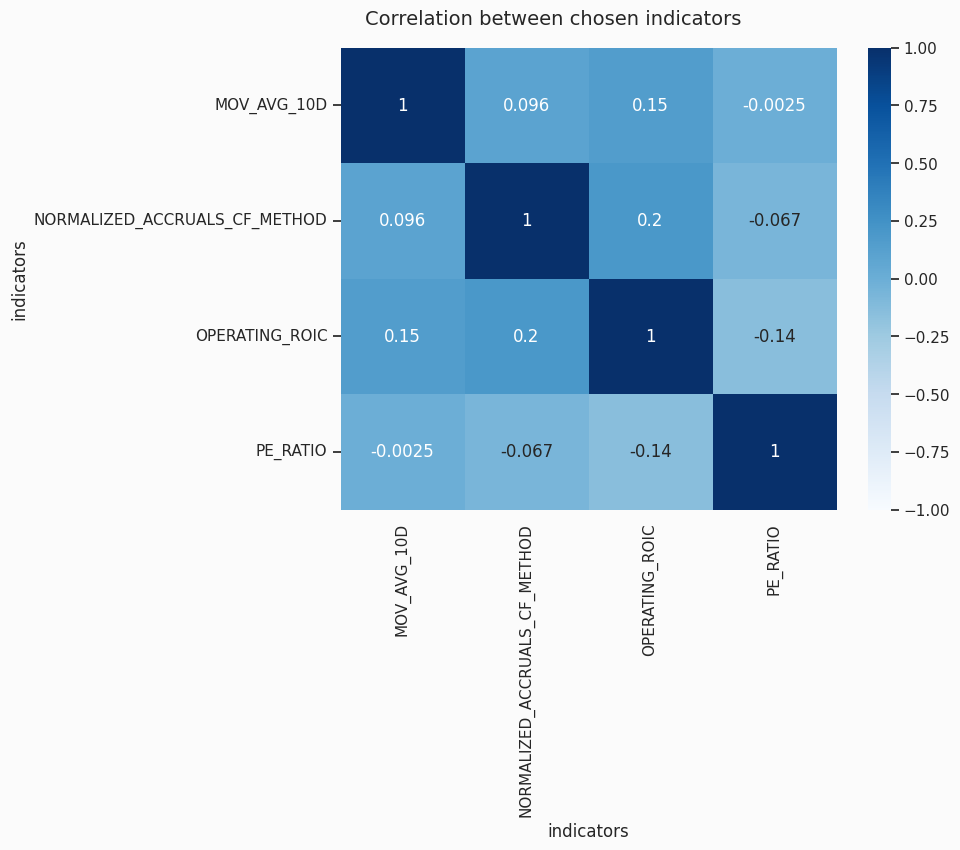

In [32]:
# get indicators and plot their correlation
ind_strategy = sel_z_score.columns.get_level_values(0).unique()

corr = df[ind_strategy].stack().corr(method='kendall')
fig, ax = plt.subplots(figsize=(8,6))
sns.heatmap(corr, vmin=-1, vmax=1, cmap='Blues', annot=True, cbar=True)
Xstart, Xend = ax.get_xlim()
Ystart, Yend = ax.get_ylim()

ax.text(Xstart+0.2, Yend-0.2, '''Correlation between chosen indicators''', fontsize=14)

x_tick_positions = [0, 1, 2, 3, 4]
#ax.set_xticks(x_tick_positions)

# ax.set_xticklabels(labels, rotation=35, ha='right')
# ax.set_yticklabels(labels, rotation=0)

#ax.set_xticks([])
ax.xaxis.set_ticks_position('none')
for s in ['top','right','bottom','left']:
    ax.spines[s].set_visible(False)
#plt.savefig("new_heatmap.png")
#plt.tight_layout()
plt.show()

In [33]:
def calculate_quantile_returns_zcomposite(data_frame, column_name, returns_df, num_quantiles=5):
    """
    Calculate quantile returns based on the specified column in the DataFrame.
    """

    quantile_ranks = pd.DataFrame(index=data_frame.index, columns=data_frame.columns)
    ind_rank = data_frame[column_name]
    ind_rank = ind_rank.replace(0, np.nan)

    for date in ind_rank.index:

        row_values = ind_rank.loc[date]

        if row_values.count() > 1:
          ranks = pd.Series(row_values).rank(method='max')
          quintiles = pd.qcut(ranks, q=num_quantiles, labels=False)
          quantile_ranks.loc[date] = quintiles

    quantile_dfs = {}
    portfolio_returns = pd.DataFrame()

    for quantile in range(num_quantiles):
        filtered_df = returns_df[quantile_ranks == quantile]
        filtered_df_shifted = filtered_df
        quantile_dfs[quantile] = filtered_df_shifted
        portfolio_returns[quantile] = quantile_dfs[quantile].mean(axis=1).dropna()

    return quantile_dfs, portfolio_returns

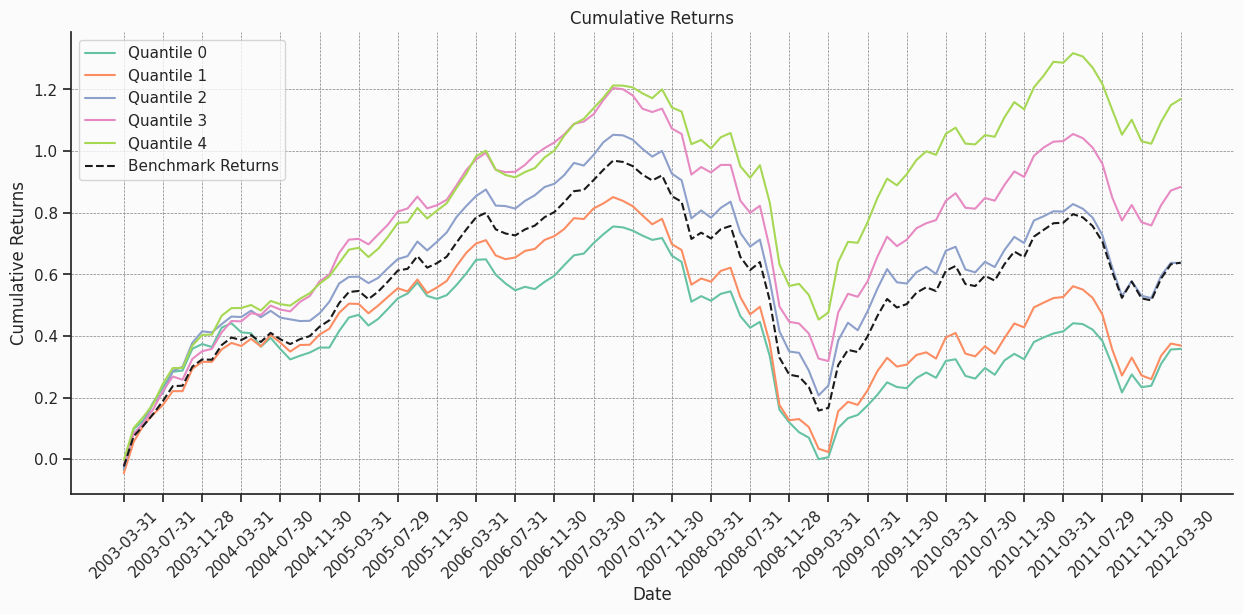

In [34]:
# compute the quantiles on the dataset that contains the composite score
result_dfs_3, portfolio_returns_3 = calculate_quantile_returns_zcomposite(final, final.columns, returns)

plt.figure(figsize=(15, 6))

# Iterate through quantiles
for quantile in range(len(portfolio_returns_3.columns)):
    plt.plot(portfolio_returns_3[quantile].cumsum(), label=f"Quantile {quantile}")


plt.plot(benchmark_returns.cumsum(), 'k--', label='Benchmark Returns')
plt.title(f"Cumulative Returns")
plt.xlabel("Date")
plt.ylabel("Cumulative Returns")

# Set x ticks for every 4 months
plt.xticks(range(0, len(portfolio_returns_3), 4), portfolio_returns_3.index[::4], rotation=45)

plt.legend()
plt.show()


indicator_IR_z_2.at[0, 'IR_max_quant'] = calculate_IR(portfolio_returns_3[4], benchmark_returns)
indicator_IR_z_2.at[0, 'tracking_error_max'] = np.std(portfolio_returns_3[4]-benchmark_returns)
indicator_IR_z_2.at[0, 'returns_max'] = np.mean(portfolio_returns_3[4]) * 100

In [35]:
indicator_IR_z_2

IR_max_quant tracking_error_max returns_max
0     0.600428            0.00811    1.072187

With this strategy we get a good enough IR but avery low tracking error.

## Strategy based just on the IR levels

The second method considers all the indicators that performed best in the Univariate strategy: we selected all the indicators that had an IR greater than 0.4 in the top or bottom quantiles, using the negative values for computing the Z-score for the bottom quantiles. This is a procedure that only takes into account the univariate results, without considering the nature of the indicators selected. For this reason, many indicators representing similar features can be selected.

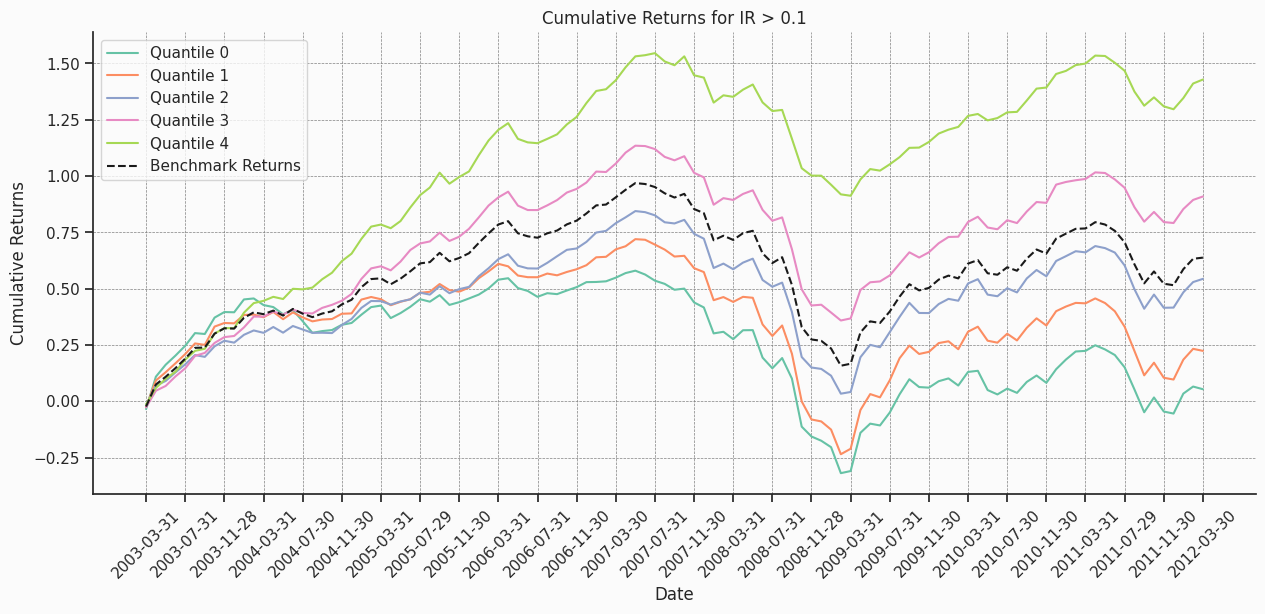

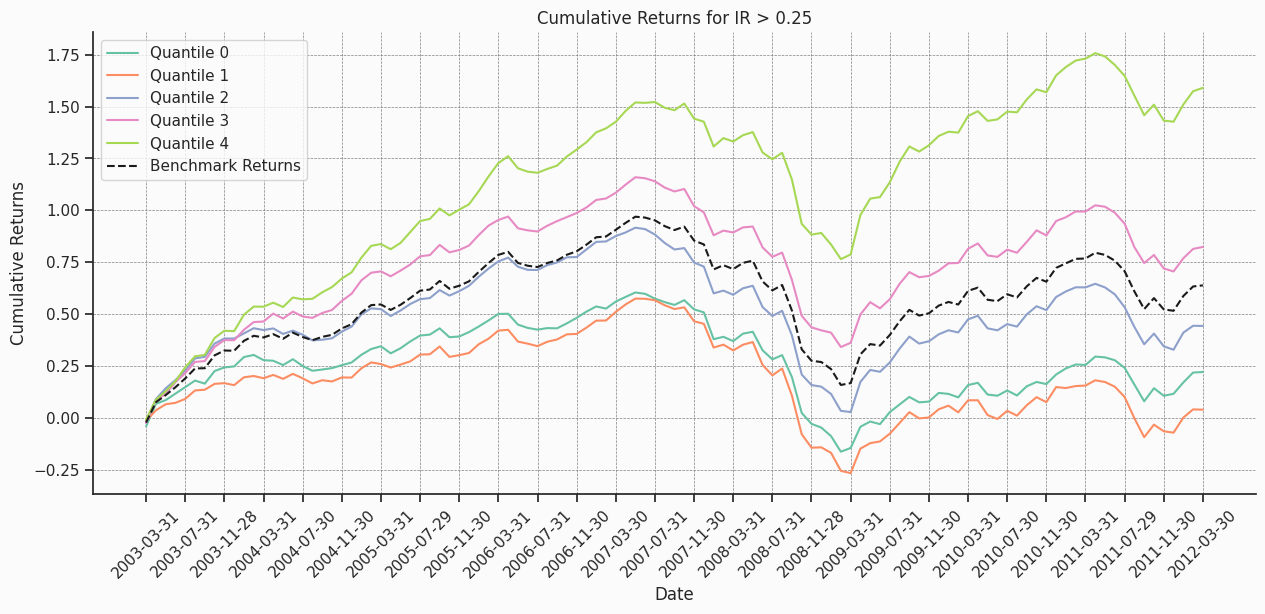

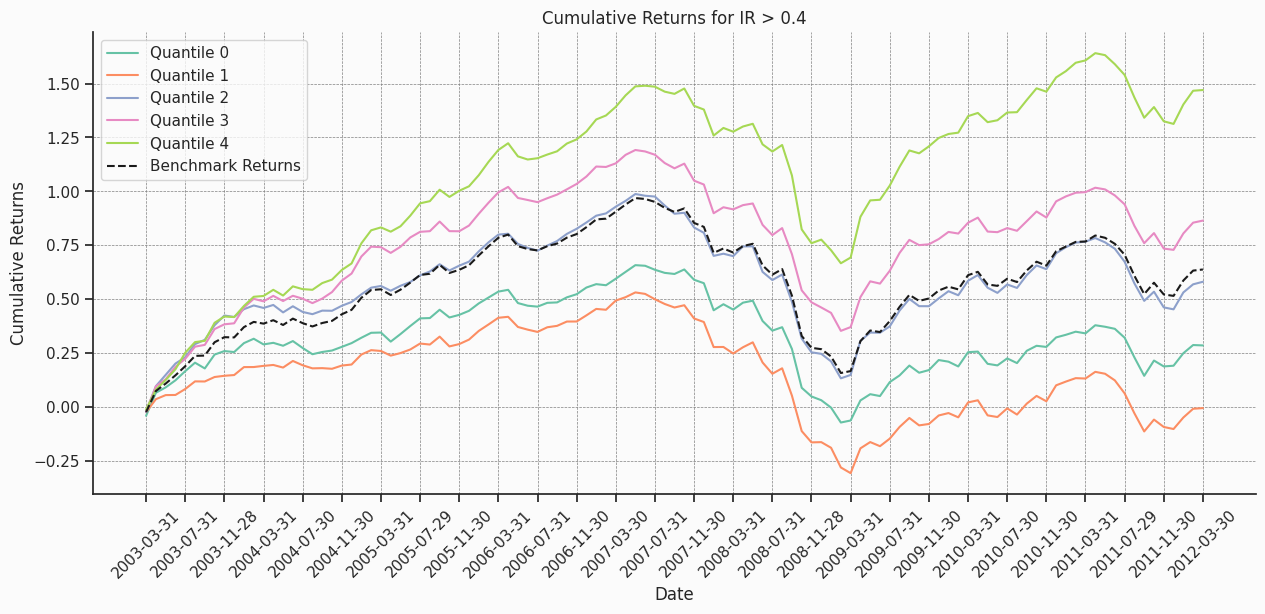

In [36]:
levels = [0.1, 0.25, 0.4]
indicator_IR_z = pd.DataFrame(index=levels, columns=['IR_max_quant', 'tracking_error_max', 'returns_max'])

for selection_level in levels:
    sel_z_score = z_score[indicator_IR[(indicator_IR['IR_top_quantile']>selection_level)].index].merge(-z_score[indicator_IR[(indicator_IR['IR_bottom_quantile']>selection_level)].index], on='Date')
    final = sel_z_score.T.groupby(level=1).sum().T

    result_dfs_2, portfolio_returns_2 = calculate_quantile_returns_zcomposite(final, final.columns, returns)

    plt.figure(figsize=(15, 6))

    # Iterate through quantiles
    for quantile in range(len(portfolio_returns_2.columns)):
        plt.plot(portfolio_returns_2[quantile].cumsum(), label=f"Quantile {quantile}")
    plt.plot(benchmark_returns.cumsum(), 'k--', label='Benchmark Returns')
    plt.title(f"Cumulative Returns for IR > {selection_level}")
    plt.xlabel("Date")
    plt.ylabel("Cumulative Returns")

    # Set x ticks for every 4 months
    plt.xticks(range(0, len(portfolio_returns_2), 4), portfolio_returns_2.index[::4], rotation=45)

    plt.legend()
    plt.show()

    indicator_IR_z.at[selection_level, 'IR_max_quant'] = calculate_IR(portfolio_returns_2[4], benchmark_returns)
    indicator_IR_z.at[selection_level, 'tracking_error_max'] = np.std(portfolio_returns_2[4]-benchmark_returns)
    indicator_IR_z.at[selection_level, 'returns_max'] = np.mean(portfolio_returns_2[4]) * 100

The graphs show the returns changing the level of IR treshold used to select the factors to compute the composite Z-score.

In [37]:
indicator_IR_z

IR_max_quant tracking_error_max returns_max
0.10     0.449223           0.016149    1.310658
0.25     0.796362            0.01097    1.458805
0.40     0.596782           0.012791    1.348577

The strategy by selecting indicators with an IR>0.25 on the unvariate strategy is the best, wiht the highest IR, lowest tracking error and highest returns.



In [38]:
selected_rows = (
    (indicator_IR['IR_top_quantile'] > 0.25) |
    (indicator_IR['IR_bottom_quantile'] > 0.25)
)

indicator_IR[selected_rows].index

Index(['CURRENT_EV_TO_12M_SALES', 'CURRENT_EV_TO_T12M_EBITDA', 'CUR_MKT_CAP',
       'FIVE_YEAR_AVG_EV_TO_T12_EBITDA', 'FIVE_YR_AVG_PRICE_EARNINGS',
       'MOV_AVG_10D', 'MOV_AVG_20D', 'MOV_AVG_30D', 'MOV_AVG_40D',
       'MOV_AVG_50D', 'MOV_AVG_5D', 'NET_DEBT_PER_SHARE',
       'NORMALIZED_ACCRUALS_BS_METHOD', 'NORMALIZED_ACCRUALS_CF_METHOD',
       'OPERATING_ROIC', 'PE_RATIO', 'PX_LAST', 'PX_TO_TANG_BV_PER_SH'],
      dtype='object', name='indicators')

These are the indicators selected.

## Machine Learning to explain returns

In [39]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.pipeline import make_pipeline
from sklearn import metrics

We implement a Random Forest Regressor that tries to explain the returns of the equity for the following month given the input factors used in the previous models. We compare the metrics of the regressor with a Linear Regression model to have a benchmark of the results obtained.

We choose to use a Random Forest because is well known to be one of the best performer models. Furthermore, it is very versatile and less computationally expensive than other machine learning models.

#### How to impute missing values?

We tried some methods, the results were best when selecting the KNN() algorithm with n_neighbors=3. We also plotted the results of the imputation of the KNN and Mean constant imputation. From the the plots we can see how KNN is able to respect better the initial distribution of the subset.

In [45]:
subset = data_stack.loc['2003-03-31':'2004-02-27']

imp_mean = SimpleImputer(missing_values=np.nan, strategy='mean')
imputer = KNNImputer(n_neighbors=2)

subset_mean = imp_mean.fit_transform(subset)
subset_knn = imputer.fit_transform(subset)

subset = subset.values

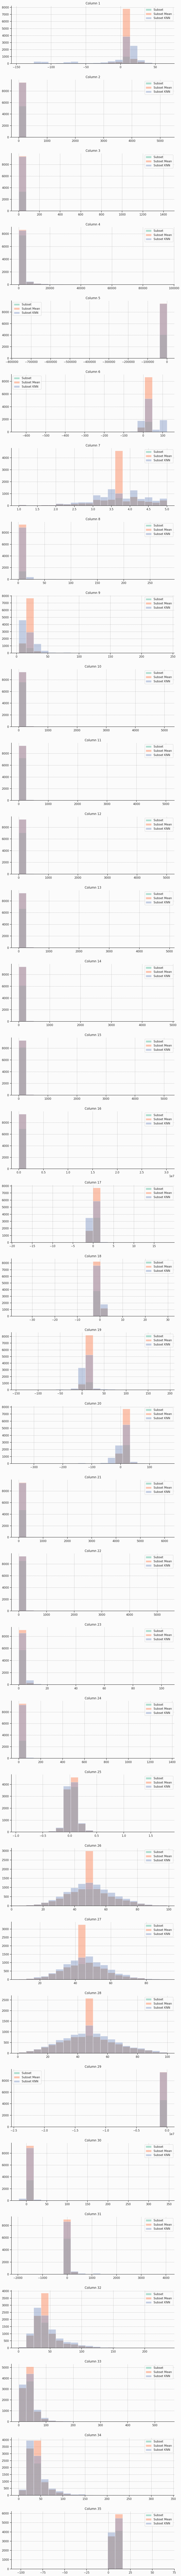

In [46]:
num_columns = subset.shape[1]
fig, axs = plt.subplots(num_columns, figsize=(10, 4*num_columns))

# Plot the distribution of each array in each subplot
for i in range(num_columns):
    axs[i].hist(subset[:, i], alpha=0.5, label='Subset', bins=20)
    axs[i].hist(subset_mean[:, i], alpha=0.5, label='Subset Mean', bins=20)
    axs[i].hist(subset_knn[:, i], alpha=0.5, label='Subset KNN', bins=20)
    axs[i].set_title(f'Column {i+1}')
    axs[i].legend()

plt.tight_layout()
plt.show()

### Random Forest

We implement a Random Forest Regressor through the Scikit Learn library. We use a rolling window to train and test the model, simulating a real time situation where the user knows the indicators and returns for the last months and tries to predict the returns for the following month given the indicators of the present month. The rolling window is 12 month wide, and is shifted by one month at every iteration. At each iteration a model is trained on the 12 month rolling window and tries to use the following month data to predict the returns. Then, the rolling window is shifted by one month and the process is repeated.

Finally, regression metrics are computing (MAE, MSE and RMSE), confronting the predictions with the actual returns of the stocks.

In [47]:
def xs_forest(df, n_estimators=4):
    '''Build a cross-sectional forest model and
    output the pipeline at each timestamp'''
    # sklearn does not have an imputing method unless specified
    df = df[df['RETURNS'].notna()]
    # do not leave out test sample in our training pipeline
    X_train, y_train = df.shift(1).drop(columns='RETURNS').values, df['RETURNS'].values

    model = make_pipeline(KNNImputer(n_neighbors=3),
                          RandomForestRegressor(n_estimators=n_estimators,
                                                random_state=42))
    model.fit(X_train, y_train)
    # we return the model instead of slope estimations
    # such that we can transform the next-period data later
    return model

In [48]:
ls_forest = {}
ts = df.index.to_list()
dt = 12                                # 1-year rolling window
for i in range(len(ts)-dt+1):
    df3 = data_stack.loc[ts[i]:ts[i+dt-1]]
    ls_forest[ts[i+dt-1]] = xs_forest(df3)    # add the model corresponding to i+dt-1, last period of rolling window
df_forest = pd.Series(ls_forest)

res = {}

for t in df_forest.shift(1).index.to_list():
    df4 = data_stack.loc[t]
    df4 = df4[df4['RETURNS'].notna()]
    X_test, y_test = df4.shift(1).drop(columns='RETURNS').values, df4['RETURNS'].values
    try:
        forest = df_forest.shift(1).loc[t]
        y_pred = forest.predict(X_test).reshape(-1)  # prediction array reshaped to 1d
    except:
        y_pred = np.nan
    res[t] = pd.DataFrame({'RETURNS': y_test, 'PREDICTIONS': y_pred}, index=df4.index)

res = pd.concat(res)
res.index.names = ['Date', 'ticker']

<Axes: title={'center': 'Feature Importance expressed as Gini impurity (average on all models trained)'}, xlabel='indicators'>

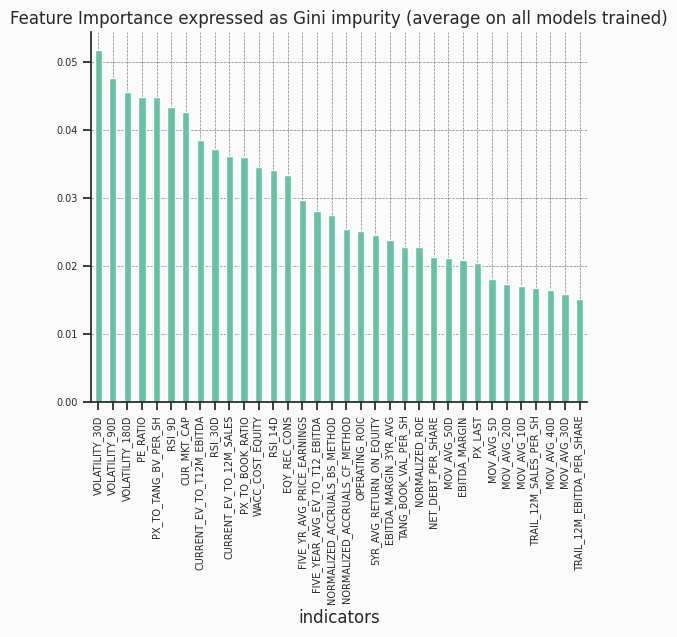

In [49]:
feature_importance = pd.DataFrame()
for i in range(len(ts)-dt+1):
  feature_importance[ts[i+dt-1]] = ls_forest[ts[i+dt-1]][1].feature_importances_
impo_means = feature_importance.mean(axis = 1)
features = pd.Series(impo_means.values, data_stack.drop('RETURNS', axis=1).columns)
features.sort_values(ascending=False).plot.bar(fontsize=7, title='Feature Importance expressed as Gini impurity (average on all models trained)')

The machine learning model  selects as important features the Volatily computed on different periods, the PE_RATIO,  the Price to Tangible Book Value per Share and the Current Market Capitalization.

In comparison to the Univariate Analysis the Machine Learning model picks different factors as important ones.

In [50]:
df_ret = res.drop('2004-02-27', level=0, axis=0)['RETURNS']
df_pred = res.drop('2004-02-27', level=0, axis=0)['PREDICTIONS']
print('Root Mean Squared Error (RMSE):', round(metrics.mean_squared_error(df_ret, df_pred, squared=False),ndigits=3))
print('Mean Absolute Error (MAE):', round(metrics.mean_absolute_error(df_ret, df_pred),ndigits=3))
print('Mean Squared Error (MSE):', round(metrics.mean_squared_error(df_ret, df_pred),ndigits=3))

Root Mean Squared Error (RMSE): 0.124
Mean Absolute Error (MAE): 0.089
Mean Squared Error (MSE): 0.015


The output metrics are good, showing a good ability of the model to predict the returns.

### Linear Regression

We apply a Linear Regression using the same method described before, to have a benchmark for the results obtained by the Random Forest Regressor.

In [51]:
def xs_lr(df, n_estimators=4):
    '''Build a cross-sectional linear regression model and
    output the pipeline at each timestamp'''
    # sklearn does not have an imputing method unless specified
    df = df[df['RETURNS'].notna()]
    # do not leave out test sample in our training pipeline
    X_train, y_train = df.shift(1).drop(columns='RETURNS').values, df['RETURNS'].values

    model = make_pipeline(KNNImputer(n_neighbors=3),
                          LinearRegression())
    model.fit(X_train, y_train)
    # we return the model instead of slope estimations
    # such that we can transform the next-period data later
    return model

In [52]:
ls_lr = {}
ts = df.index.to_list()
dt = 12                                # 1-year rolling window
for i in range(len(ts)-dt+1):
    df3 = data_stack.loc[ts[i]:ts[i+dt-1]]
    ls_lr[ts[i+dt-1]] = xs_lr(df3)    # add the model corresponding to i+dt-1, last period of rolling window
df_lr = pd.Series(ls_lr)

res_lr = {}

for t in df_lr.shift(1).index.to_list():
    df4 = data_stack.loc[t]
    df4 = df4[df4['RETURNS'].notna()]
    X_test, y_test = df4.shift(1).drop(columns='RETURNS').values, df4['RETURNS'].values
    try:
        lr = df_lr.shift(1).loc[t]
        y_pred = lr.predict(X_test).reshape(-1)  # prediction array reshaped to 1d
    except:
        y_pred = np.nan
    res_lr[t] = pd.DataFrame({'RETURNS': y_test, 'PREDICTIONS': y_pred}, index=df4.index)

res_lr = pd.concat(res_lr)
res_lr.index.names = ['Date', 'ticker']

<Axes: title={'center': 'Feature Importance expressed as absolute value of coefficient (average on all models trained)'}, xlabel='indicators'>

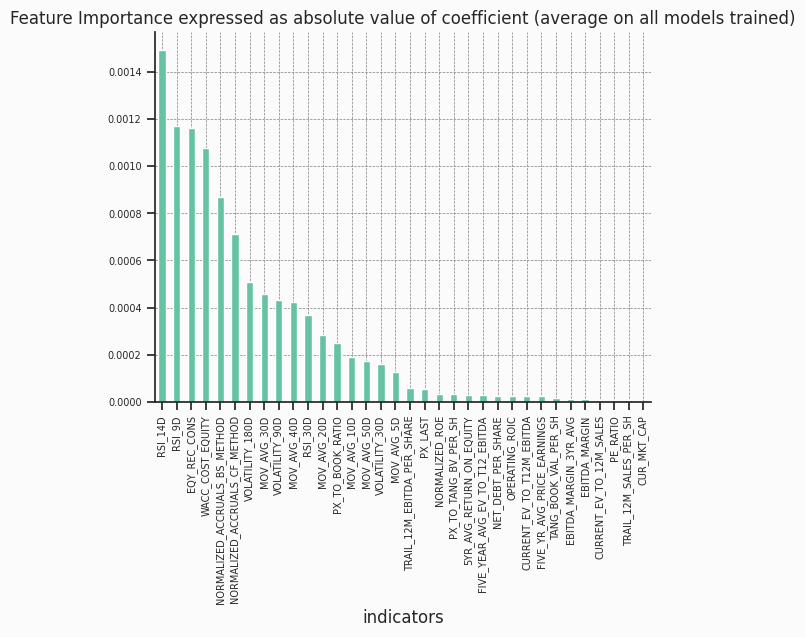

In [53]:
feature_importance_lr = pd.DataFrame()
for i in range(len(ts)-dt+1):
  feature_importance_lr[ts[i+dt-1]] = abs(ls_lr[ts[i+dt-1]][1].coef_)
impo_means_lr = feature_importance_lr.mean(axis = 1)
features_lr = pd.Series(impo_means_lr.values, data_stack.drop('RETURNS', axis=1).columns)
features_lr.sort_values(ascending=False).plot.bar(fontsize=7, title='Feature Importance expressed as absolute value of coefficient (average on all models trained)')

We can see that some important parameters selected by the Linear Regression are Relative Strenght Index combuted at 9, 14, and Consesus Equity Recommendations. The Linear Regression, furthermore, selects WACC - Cost Equity and Normalized Accruals.

In [54]:
df_ret_lr = res_lr.drop('2004-02-27', level=0, axis=0)['RETURNS']
df_pred_lr = res_lr.drop('2004-02-27', level=0, axis=0)['PREDICTIONS']

table = [['Root Mean Squared Error (RMSE):',
          round(metrics.mean_squared_error(df_ret_lr, df_pred_lr, squared=False),ndigits=3),
          round(metrics.mean_squared_error(df_ret, df_pred, squared=False),ndigits=3)
          ],
         ['Mean Absolute Error (MAE):',
          round(metrics.mean_absolute_error(df_ret_lr, df_pred_lr),ndigits=3),
          round(metrics.mean_absolute_error(df_ret, df_pred),ndigits=3)
          ],
         ['Mean Squared Error (MSE):',
          round(metrics.mean_squared_error(df_ret_lr, df_pred_lr),ndigits=3),
          round(metrics.mean_squared_error(df_ret, df_pred),ndigits=3)
          ]]

print(tabulate(table, headers=['','LR', 'RF']))

                                    LR     RF
-------------------------------  -----  -----
Root Mean Squared Error (RMSE):  0.457  0.124
Mean Absolute Error (MAE):       0.077  0.089
Mean Squared Error (MSE):        0.209  0.015


Comparing the metrics with the ones obtained with the Random Forest Regression, we can see that the ability of the Random Forest to predict the earning is way higher: its errors are, in fact, lower. Since Linear Regression is a very simple model, we expected this behaviour.
